In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

color_pal = sns.color_palette()

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [59]:
#read X data
df_X = pd.read_csv('data/Germany/input_data.csv')
df_X = df_X.set_index('time')
df_X.index = pd.to_datetime(df_X.index)

In [60]:
df_X = df_X[(df_X.index>='2002-05-01' )& (df_X.index<='2016-12-31')]


for j in ['rr','tg','tn','tx','pp','hu','fg','qq','et']:
    temps = pd.DataFrame(df_X[j].values)
    shifted = temps.shift(1)
    window_7 = shifted.rolling(window=7)
    window_long = shifted.rolling(window=90)
    means_7 = window_7.mean()
    means_long = window_long.mean()
    
    df_X['{}_avg_past_week'.format(j)]=means_7.to_numpy()
    df_X['{}_avg_long'.format(j)]=means_long.to_numpy()

# for i in ['rr','tg','tn','tx','pp','hu','fg','qq','et']:
#     temps = pd.DataFrame(df_X[i].values)
#     shifted = temps.shift(1)
#     window = shifted.rolling(window=7)
#     means = window.max()
#     df_X['{}_max_past_week'.format(i)]=means.to_numpy()

# drop first week of data after creating lag features
df_X.dropna(inplace = True)
print(df_X.shape)
df_X.head()

(5269, 27)


rr         tg         tn         tx          pp         hu    fg  \
time                                                                            
2002-07-30  0.0  23.930000  17.449999  30.260000  1009.80000  62.815002  1.50   
2002-07-31  1.4  22.340000  16.090000  28.930000  1006.60004  71.715004  1.83   
2002-08-01  5.3  18.779999  15.929999  22.590000  1009.50000  85.365005  2.36   
2002-08-02  0.0  17.650000  12.889999  23.680000  1014.60004  76.745000  1.89   
2002-08-03  0.0  20.300000  12.840000  26.949999  1012.80000  71.470000  1.29   

               qq        et  rr_avg_past_week  ...  pp_avg_past_week  \
time                                           ...                     
2002-07-30  289.0  4.824051          0.771429  ...       1016.328577   
2002-07-31  245.0  3.991608          0.771429  ...       1015.642857   
2002-08-01  152.0  2.323265          0.757143  ...       1014.814291   
2002-08-02  266.0  3.969962          1.142857  ...       1014.028577   
2002-08-03  247.0  3.878862          0.957143  ...       1013.471440   

            pp_avg_long  hu_avg_past_week  hu_avg_long  fg_avg_past_week  \
time                                                                       
2002-07-30  1014.218898         75.942858    74.856288          2.001429   
2002-07-31  1014.228898         75.305001    74.770677          1.968571   
2002-08-01  1014.213343         73.955716    74.682066          1.820000   
2002-08-02  1014.233343         74.678574    74.631233          1.821429   
2002-08-03  1014.290010         72.861430    74.438082          1.827143   

            fg_avg_long  qq_avg_past_week  qq_avg_long  et_avg_past_week  \
time                                                                       
2002-07-30     2.160111        199.428571   225.266667          3.042228   
2002-07-31     2.144778        206.428571   226.200000          3.223804   
2002-08-01     2.135111        221.285714   227.211111          3.498975   
2002-08-02     2.133667        223.285714   227.766667          3.550924   
2002-08-03     2.128000        248.857143   229.777778          3.945079   

            et_avg_long  
time                     
2002-07-30     3.318380  
2002-07-31     3.341253  
2002-08-01     3.363210  
2002-08-02     3.374144  
2002-08-03     3.406897  

[5 rows x 27 columns]

In [61]:
# check for null values
df_X[df_X['rr_avg_past_week'].isnull()]

Empty DataFrame
Columns: [rr, tg, tn, tx, pp, hu, fg, qq, et, rr_avg_past_week, rr_avg_long, tg_avg_past_week, tg_avg_long, tn_avg_past_week, tn_avg_long, tx_avg_past_week, tx_avg_long, pp_avg_past_week, pp_avg_long, hu_avg_past_week, hu_avg_long, fg_avg_past_week, fg_avg_long, qq_avg_past_week, qq_avg_long, et_avg_past_week, et_avg_long]
Index: []

[0 rows x 27 columns]

In [62]:
#read y data
df_y = pd.read_csv('data/Germany/heads.csv')
df_y = df_y.set_index('Date')
df_y.index = pd.to_datetime(df_y.index)
df_y.index = df_y.index.rename("time")

# drop first week of data
df_y = df_y[(df_y.index>=df_X.index[0])]
print(df_y.shape)
df_y.head()

(5269, 1)


head
time              
2002-07-30  374.59
2002-07-31  374.58
2002-08-01  374.57
2002-08-02  374.57
2002-08-03  374.58

what are we doing here? getting rid of outliers?

In [63]:
for i in df_X.columns:
    std = np.std(df_X[i],ddof=1)
    mean = np.mean(df_X[i])
    index = (df_X[(df_X[i]>3*std+mean) | (df_X[i]<mean-3*std)]).index
    df_X.drop(index=index,inplace=True)
    df_y.drop(index=index,inplace=True)

print(df_X.shape)
print(df_y.shape)

(4757, 27)
(4757, 1)


In [64]:
# add year, day and day of week features
def create_features(df):
    df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.day_of_week
    #df['quarter'] = df.index.quarter
    return(df)

In [68]:
df_X = create_features(df_X)

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


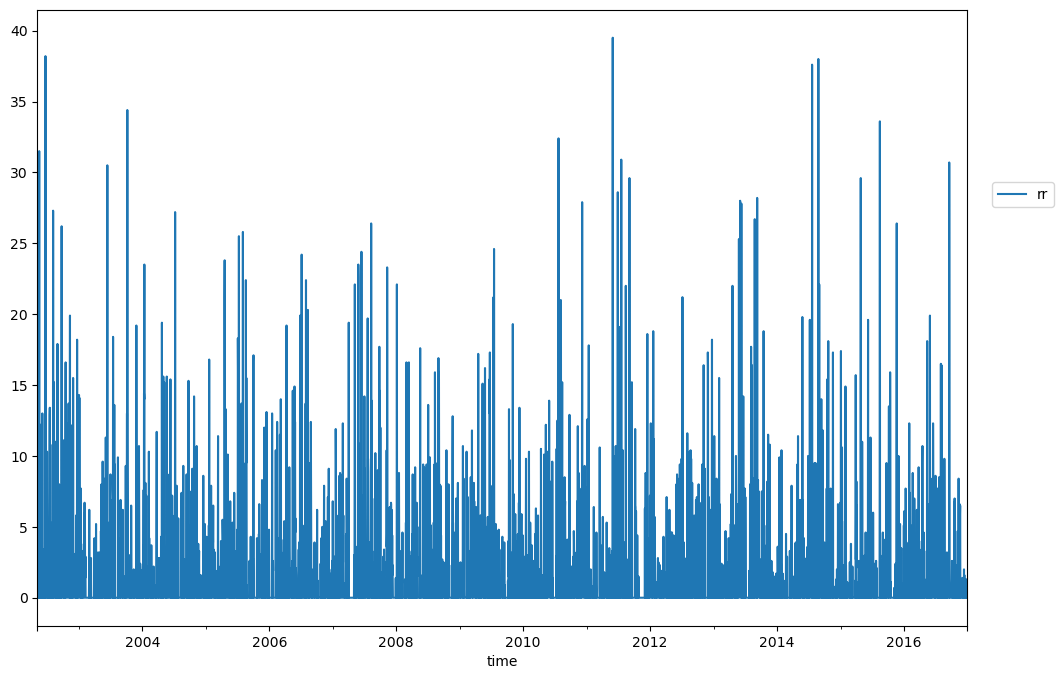

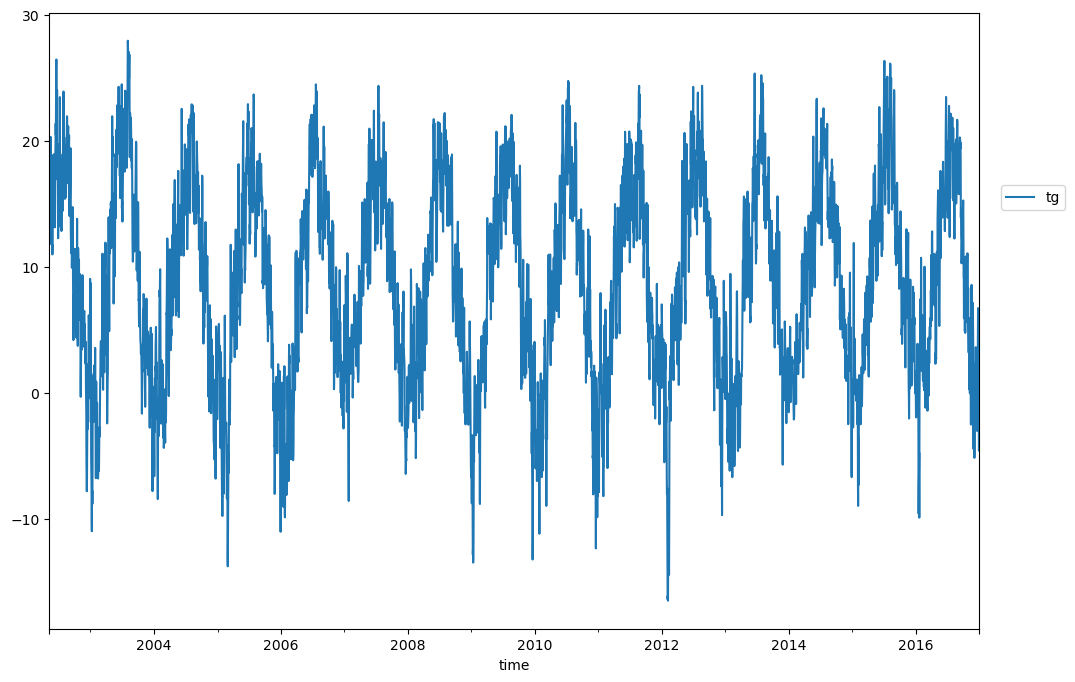

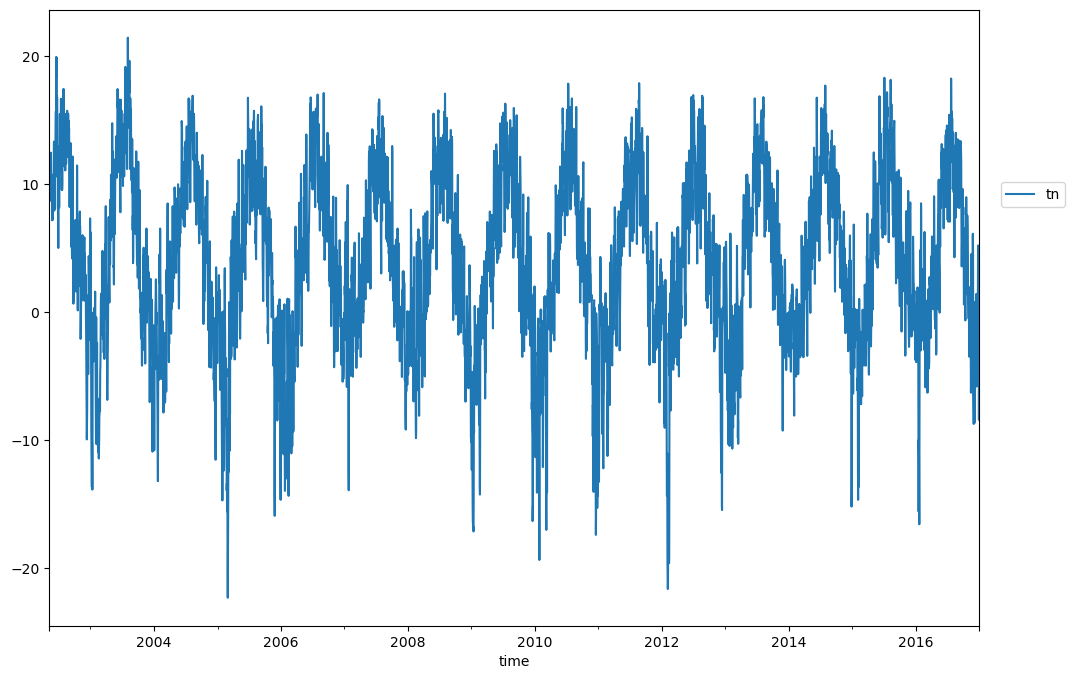

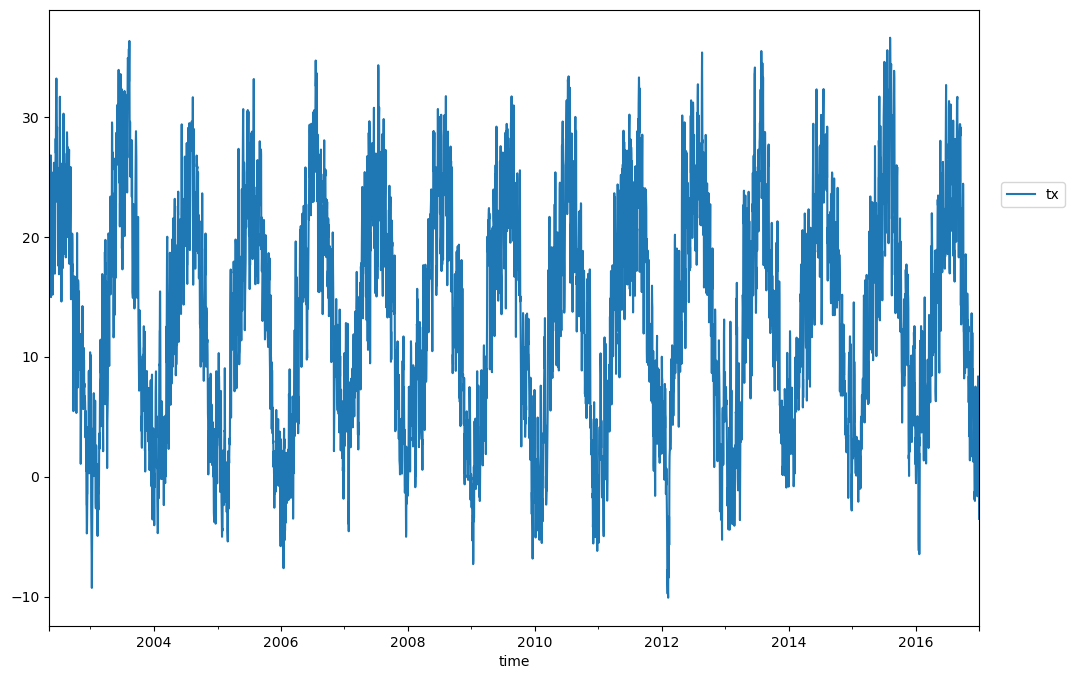

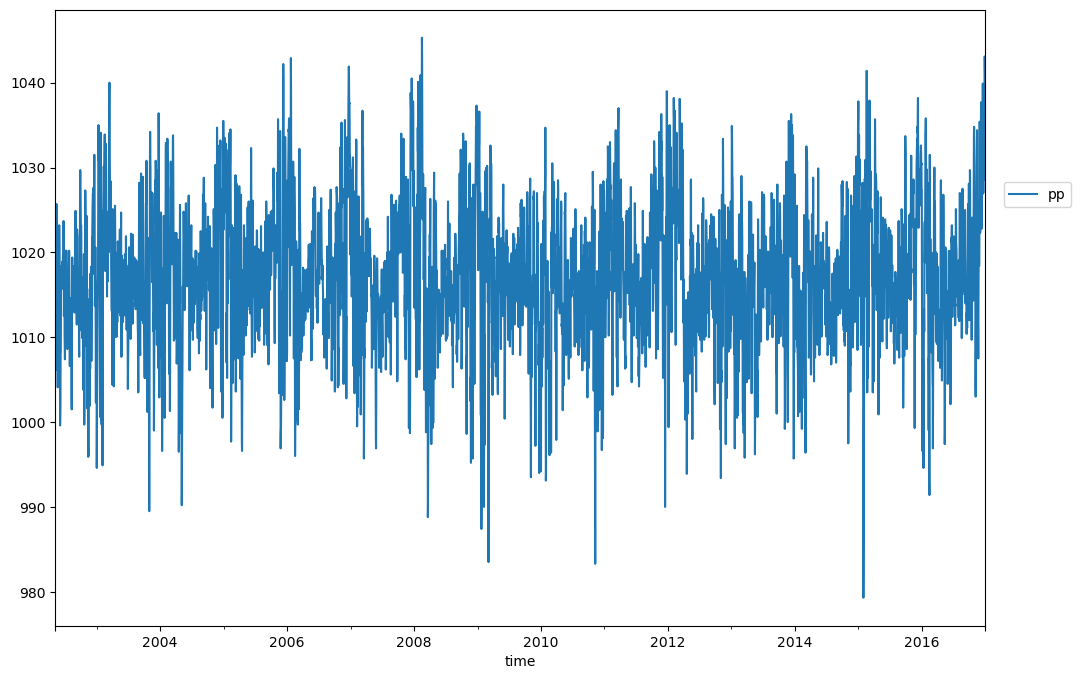

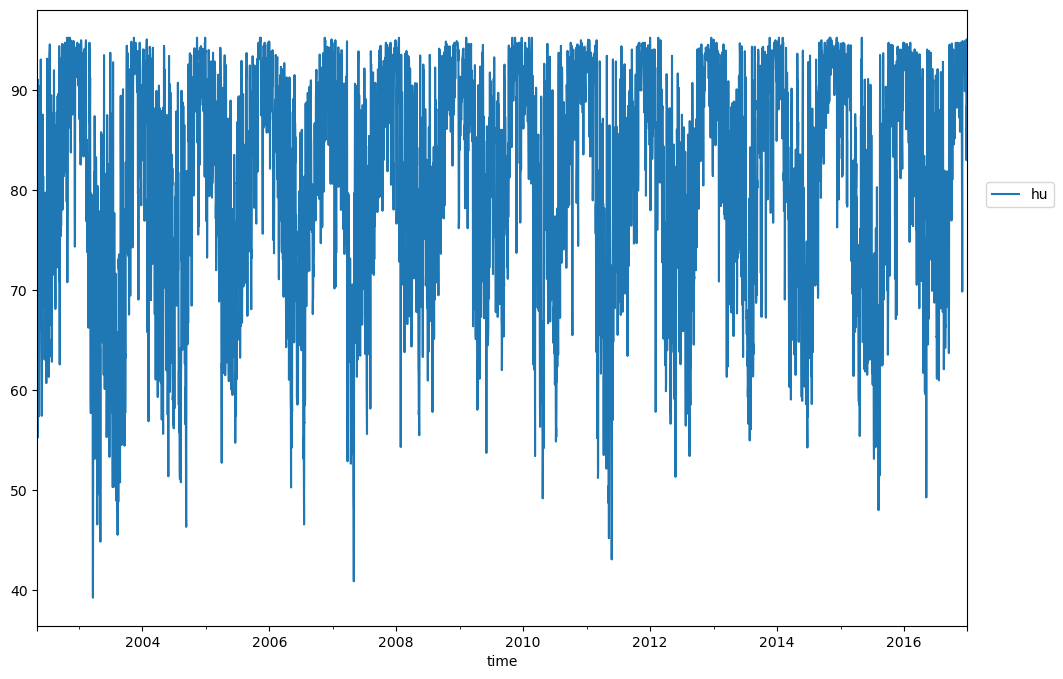

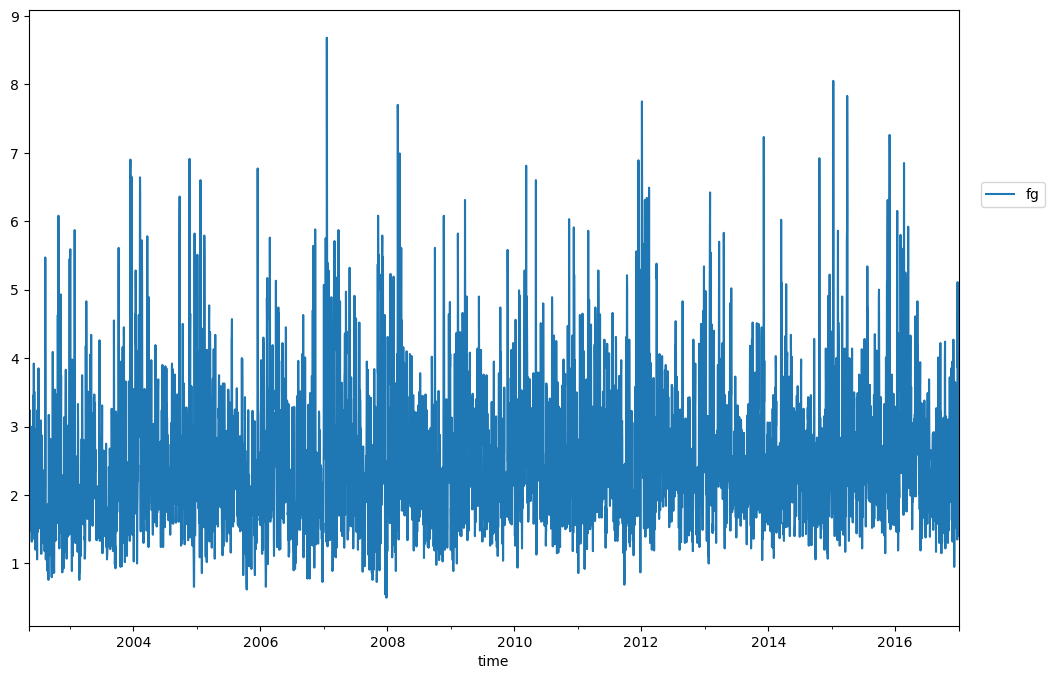

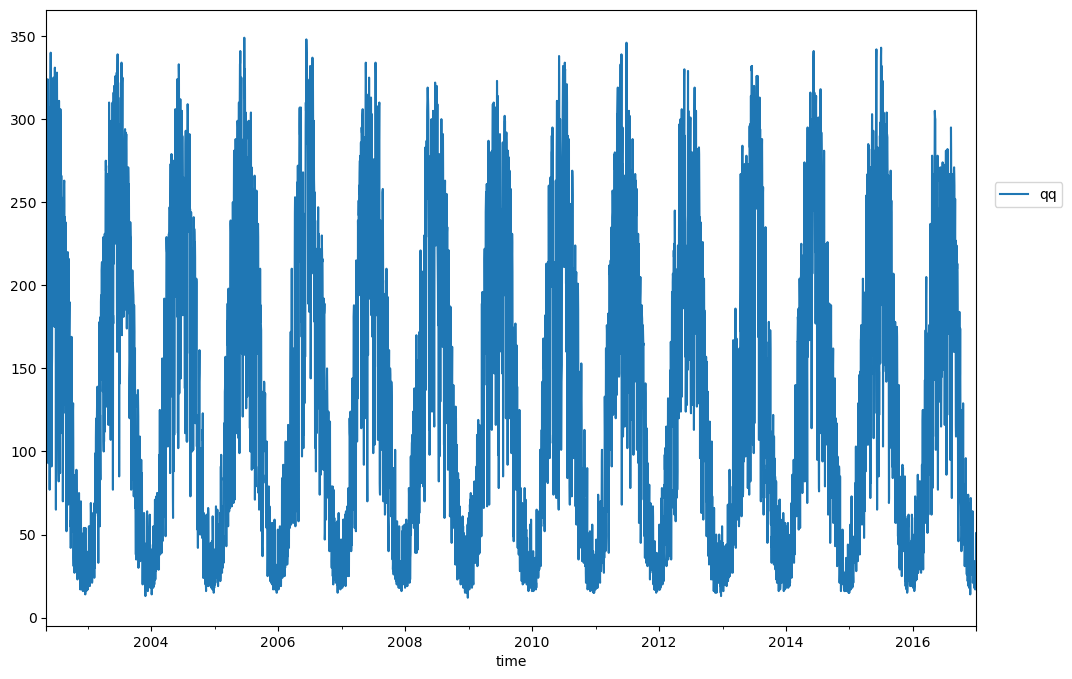

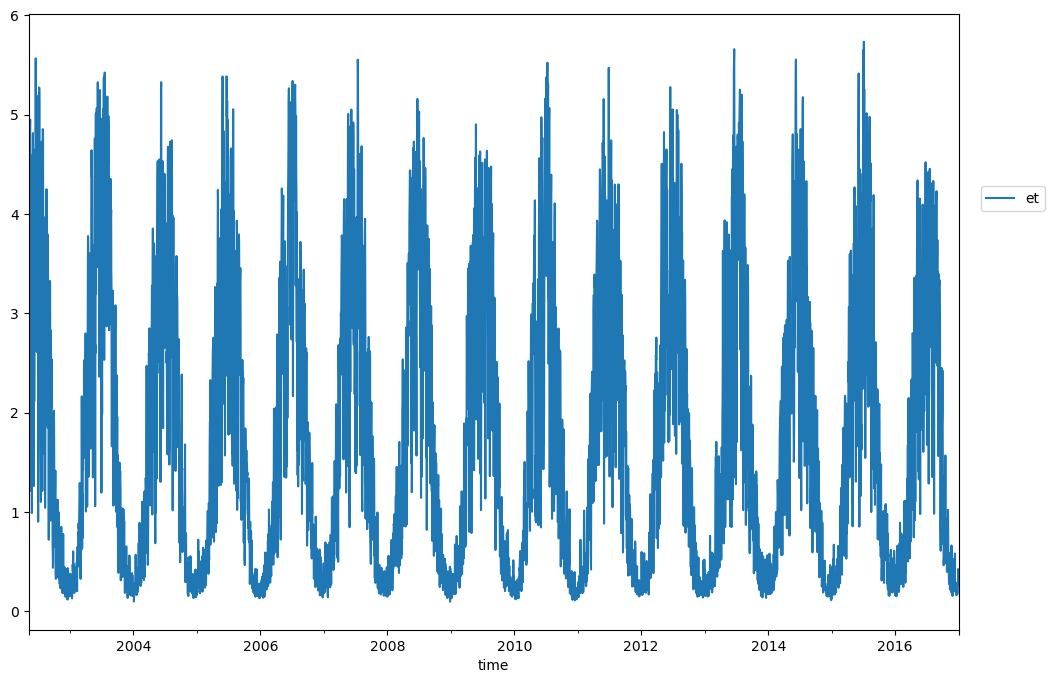

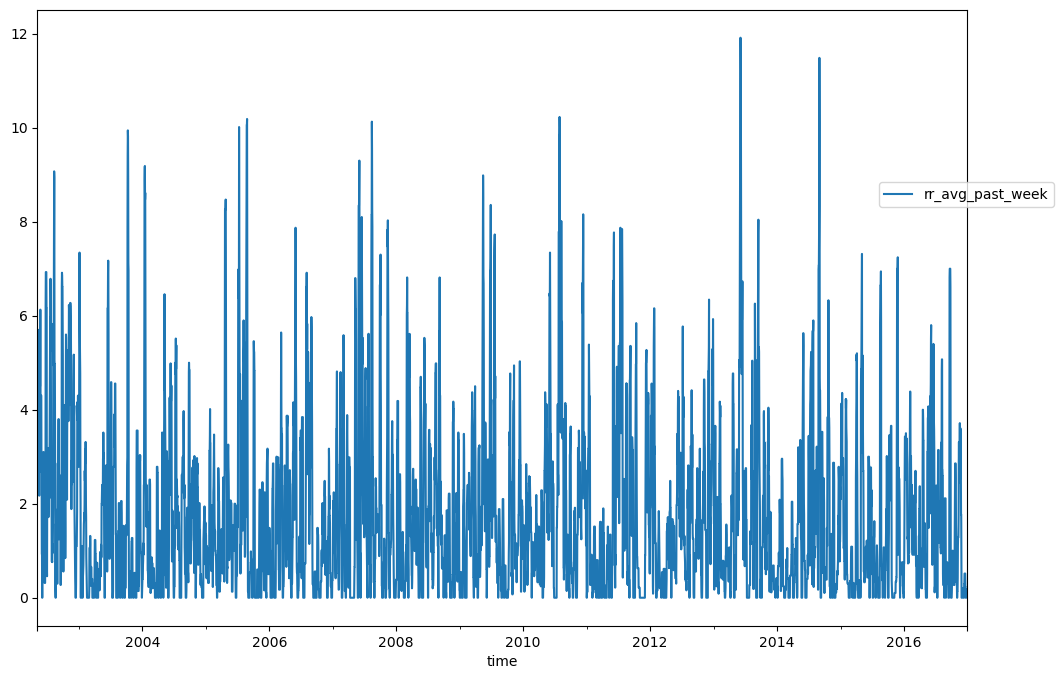

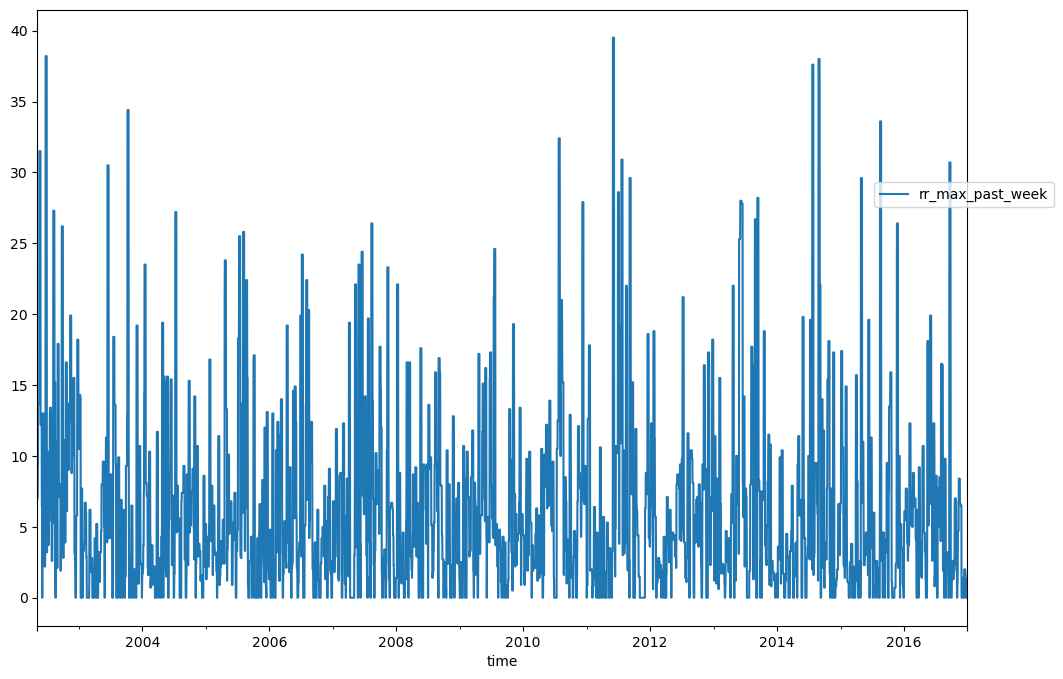

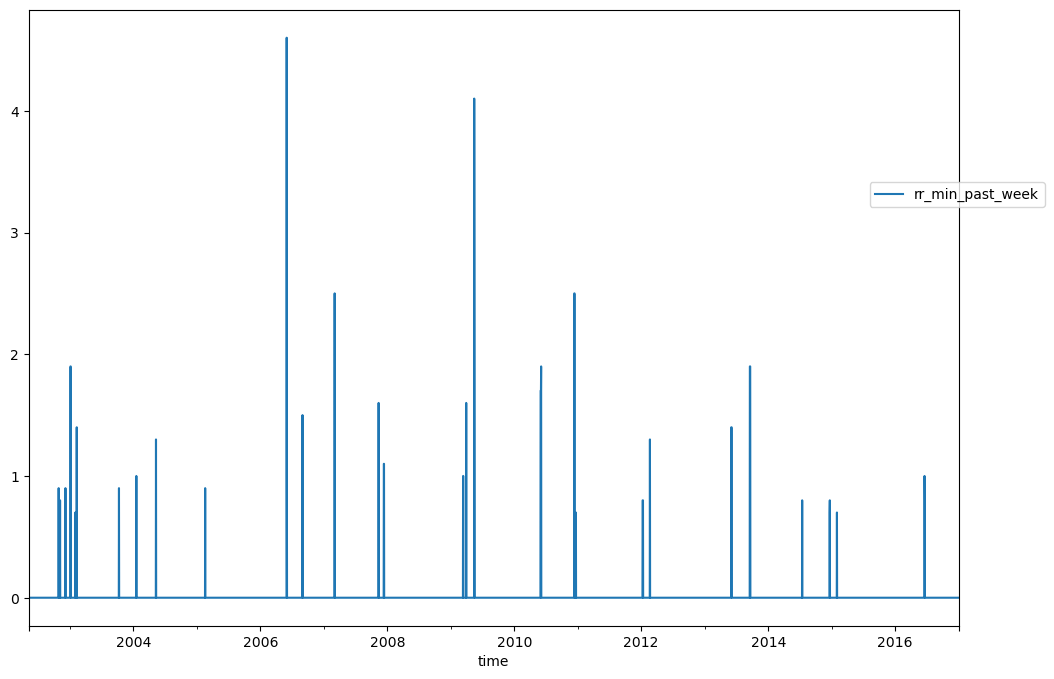

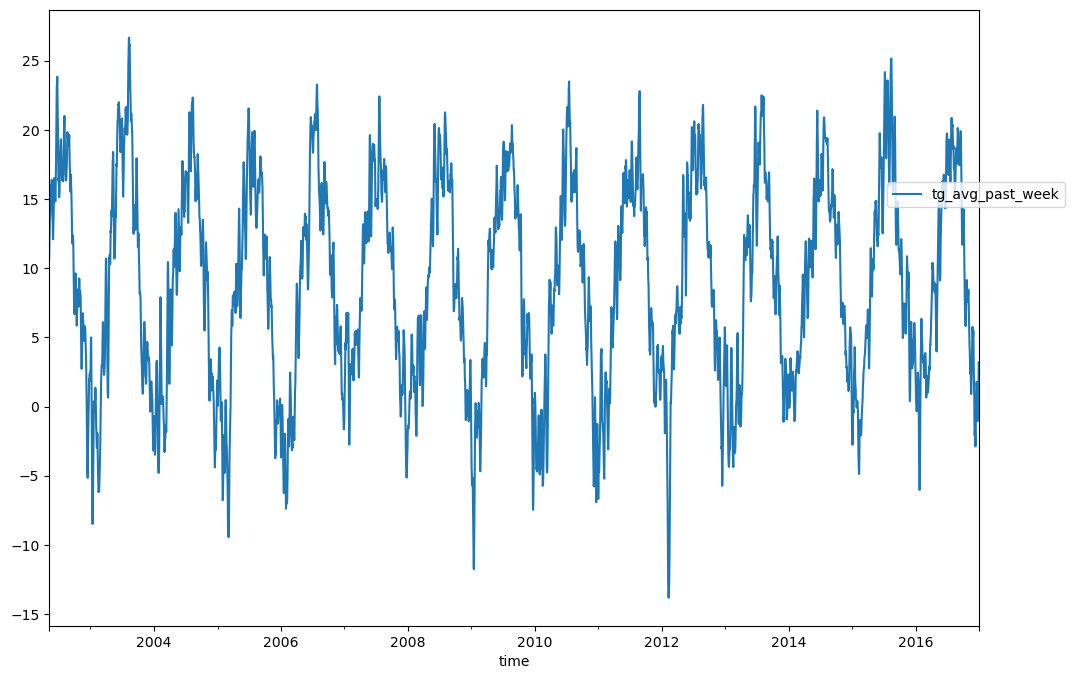

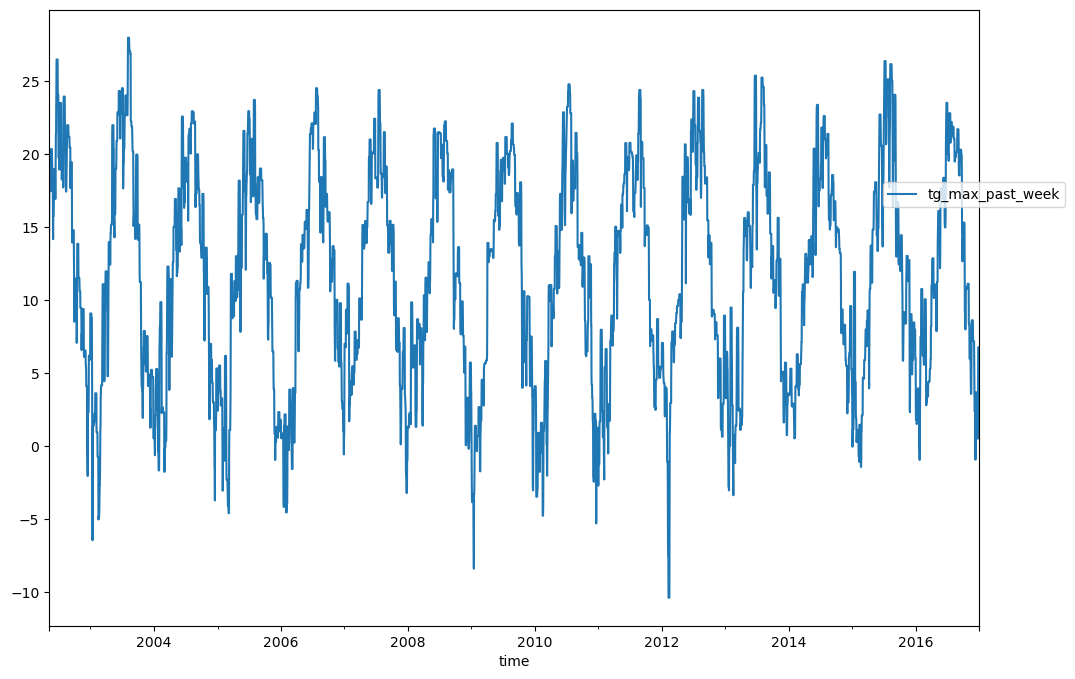

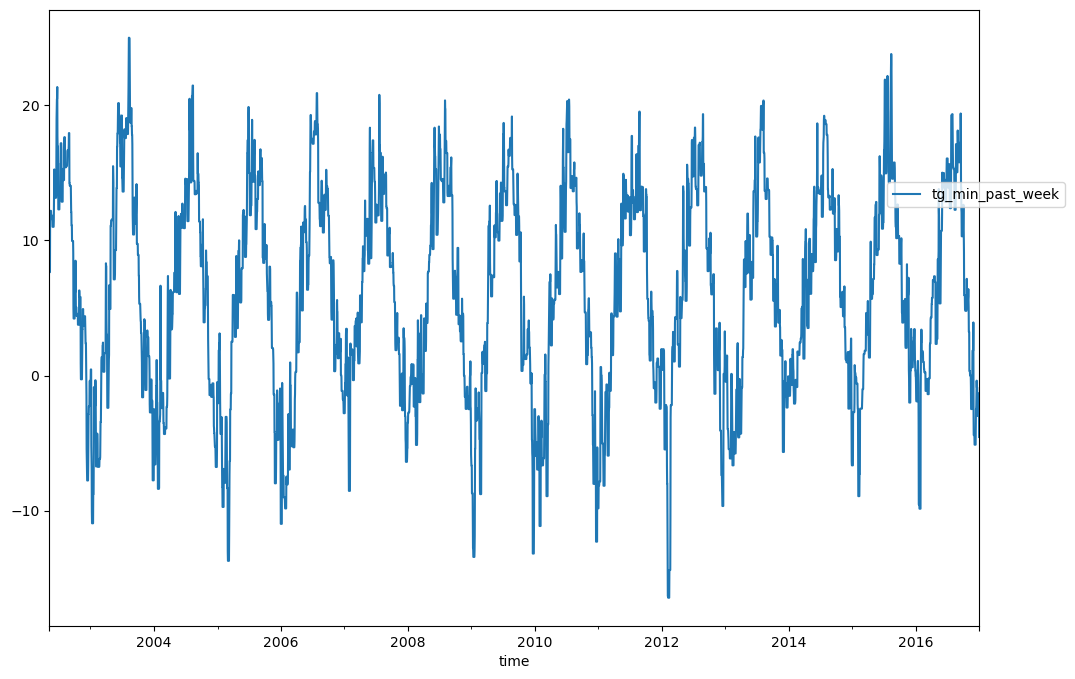

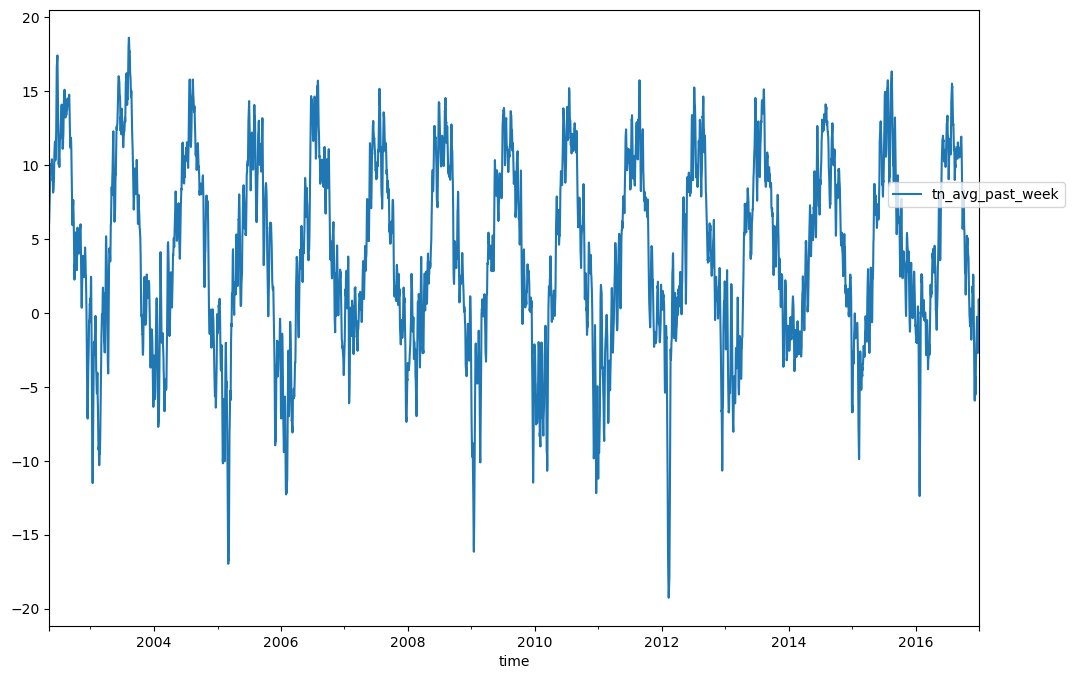

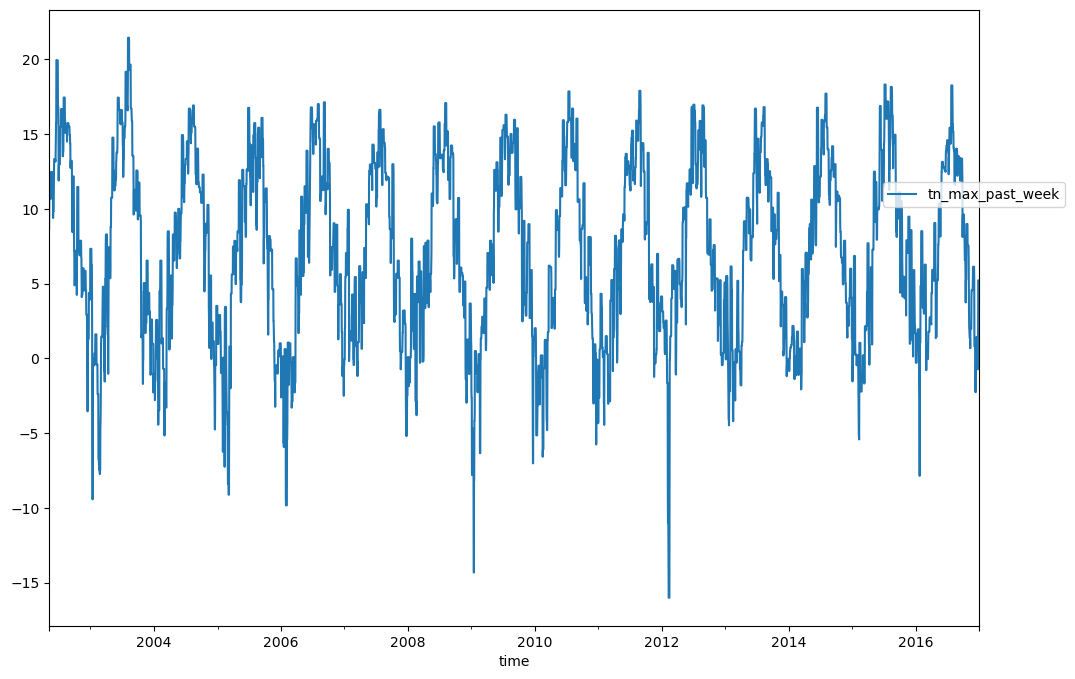

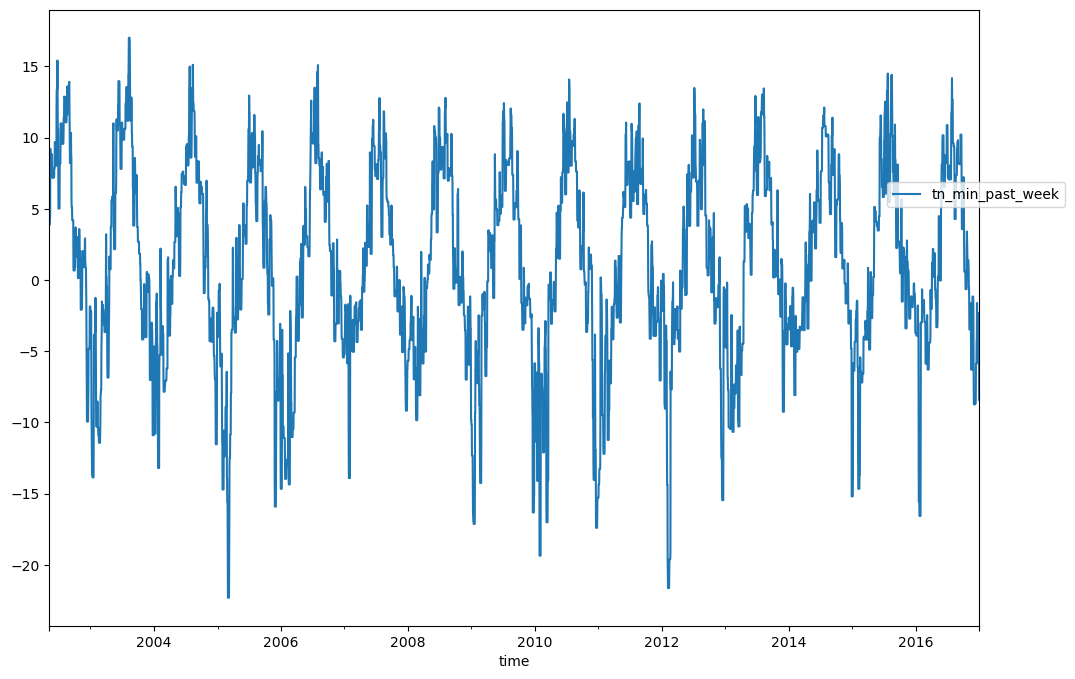

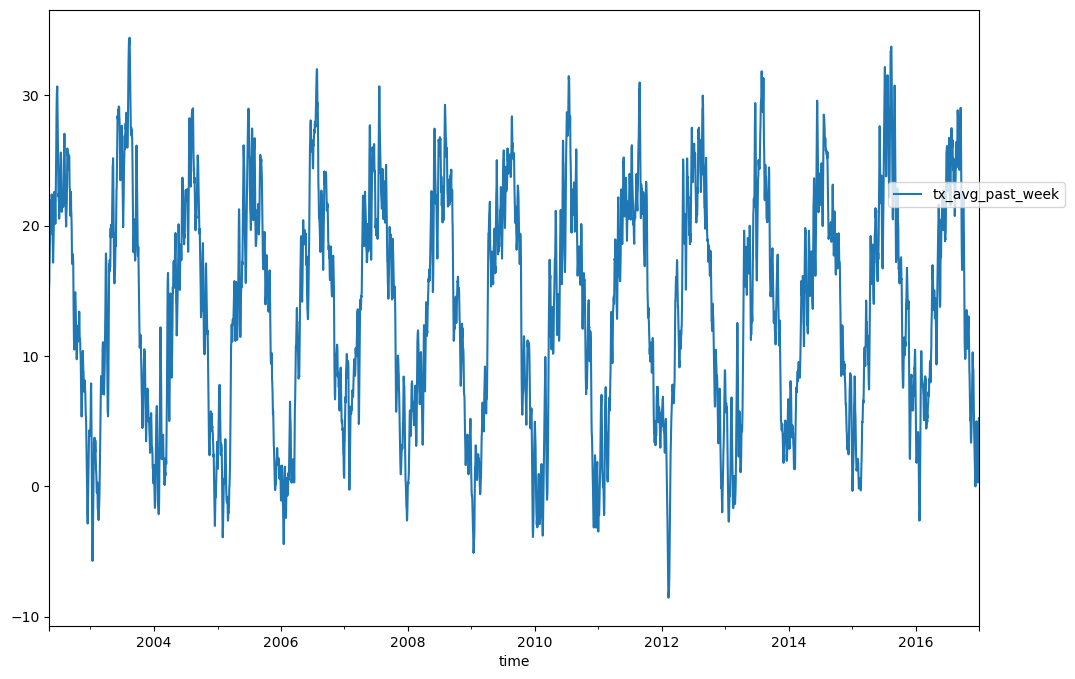

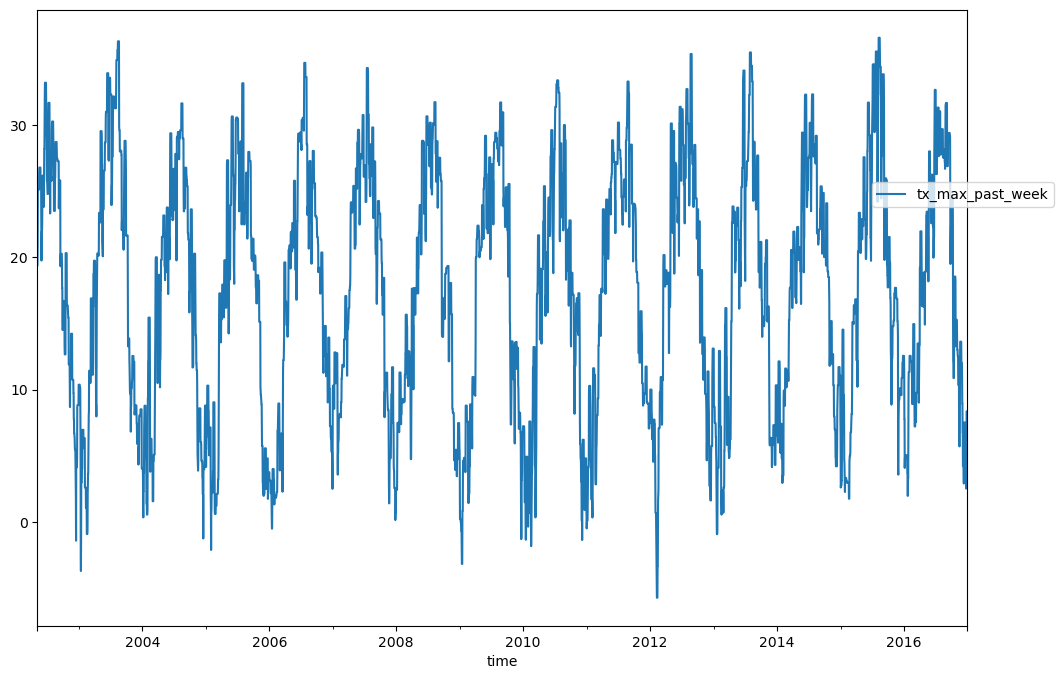

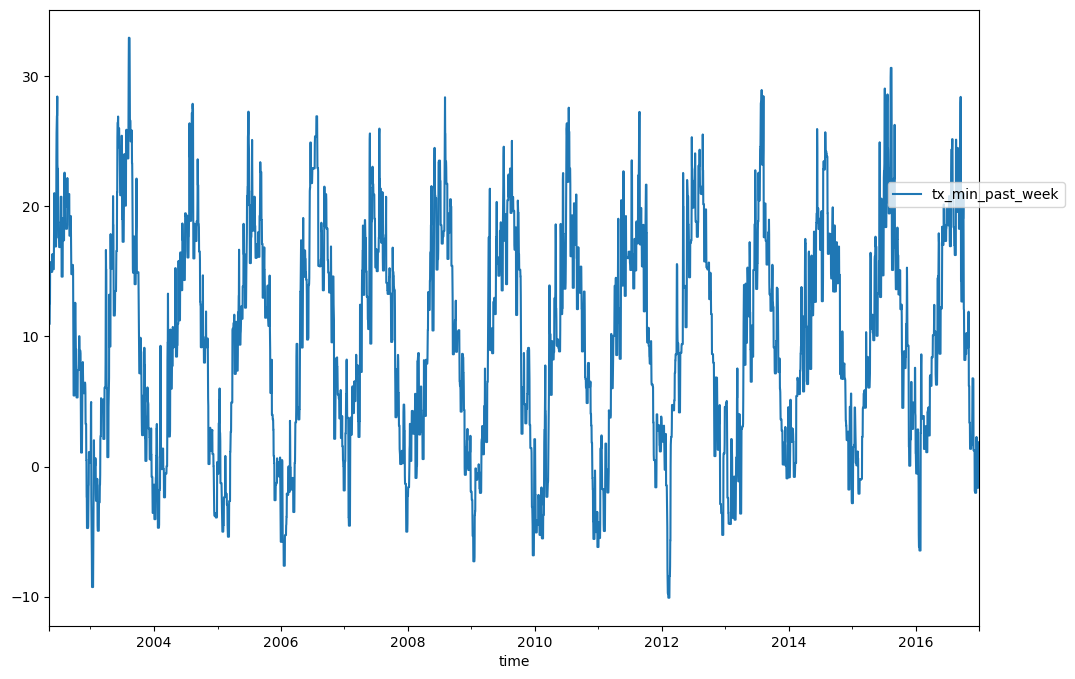

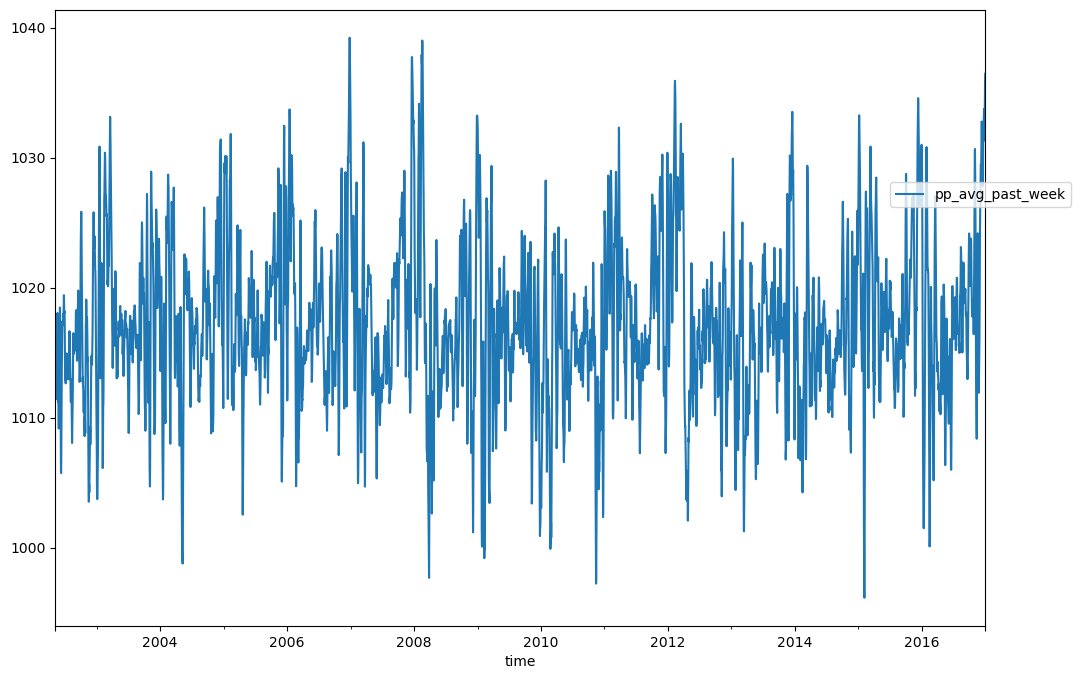

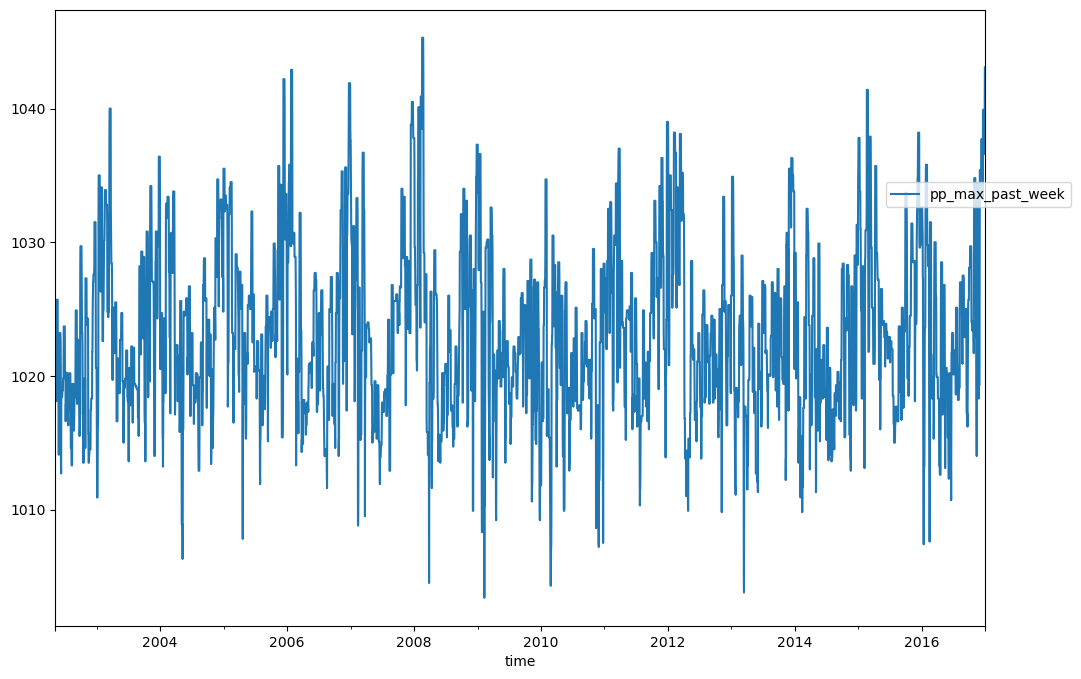

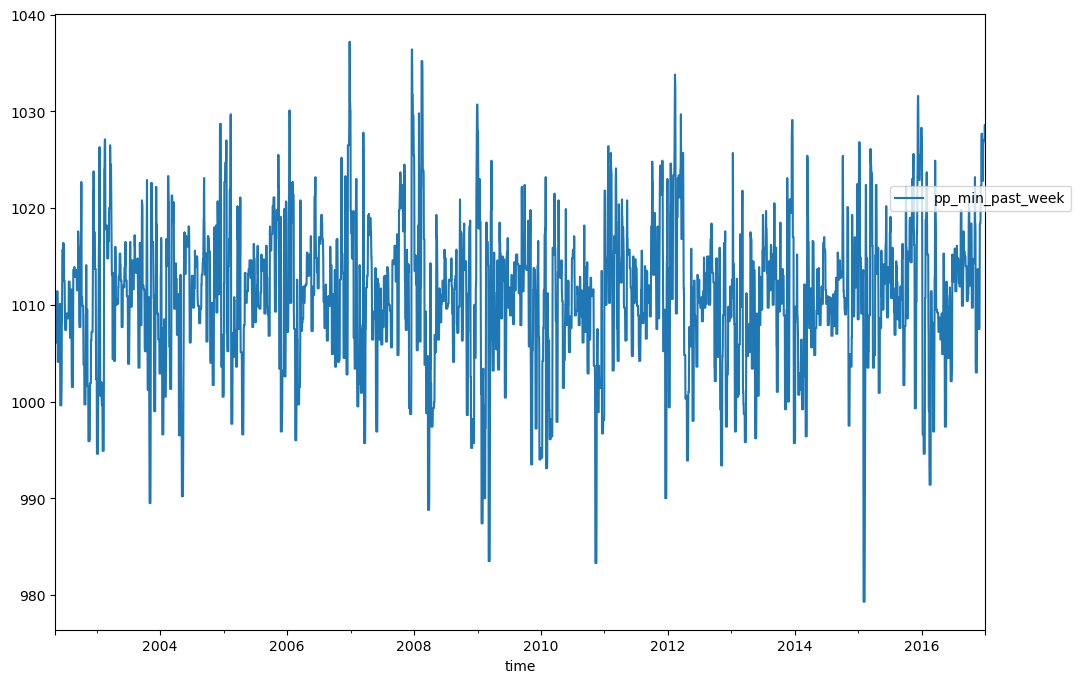

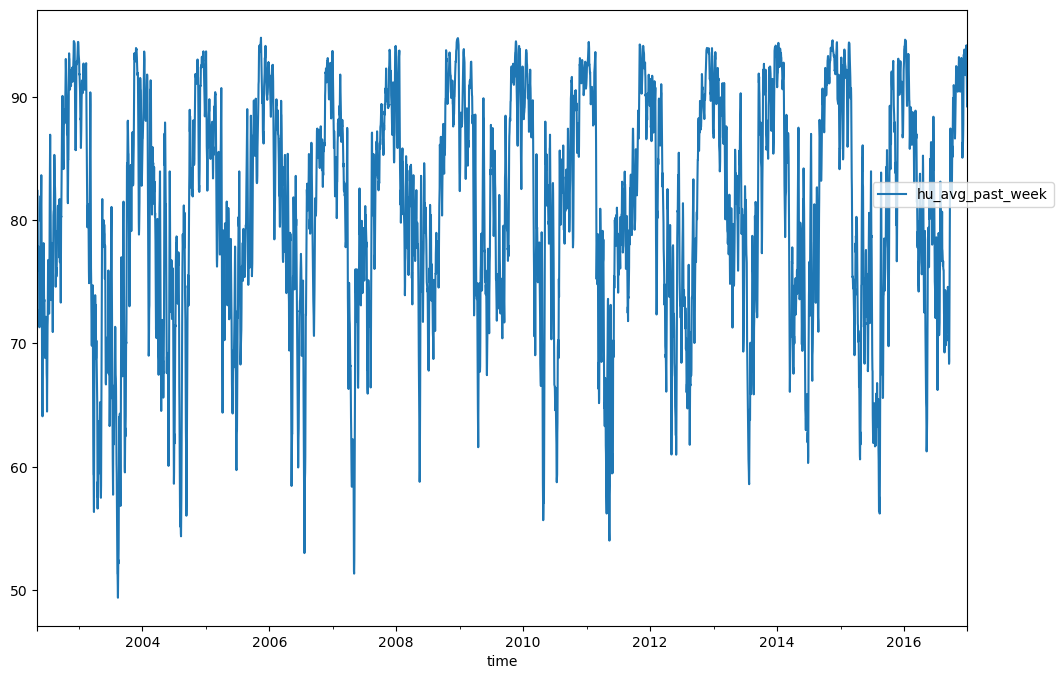

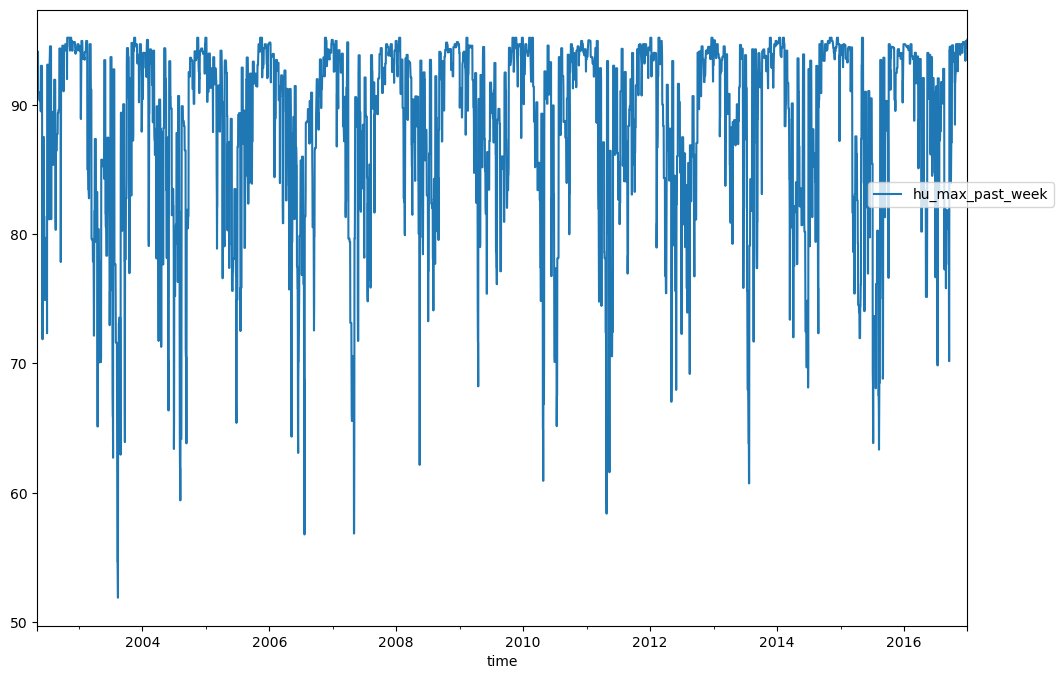

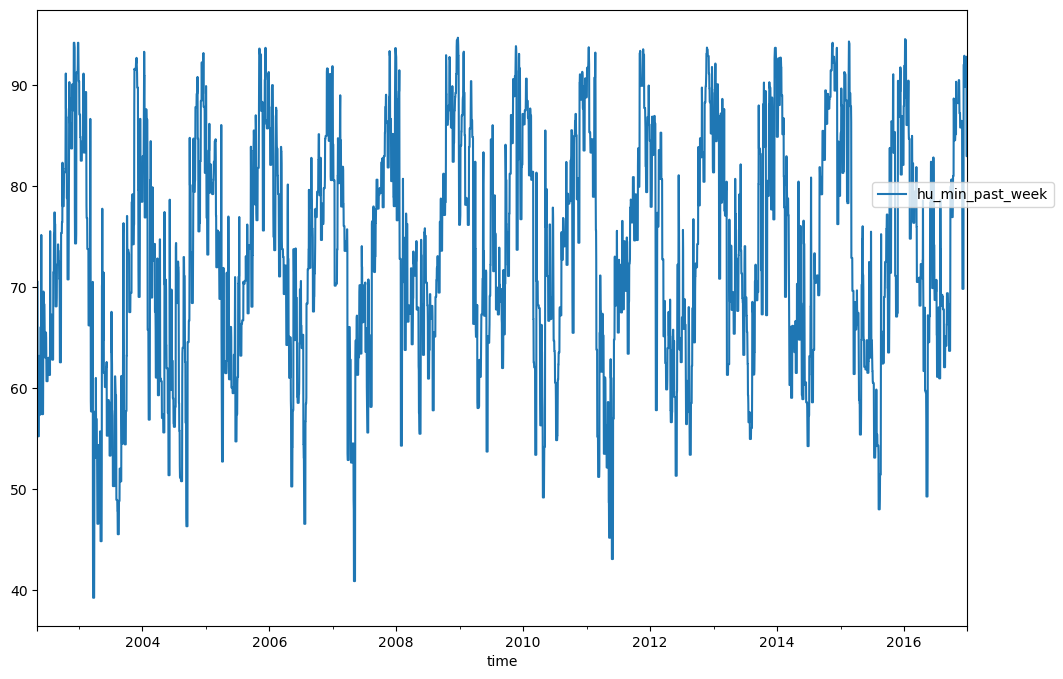

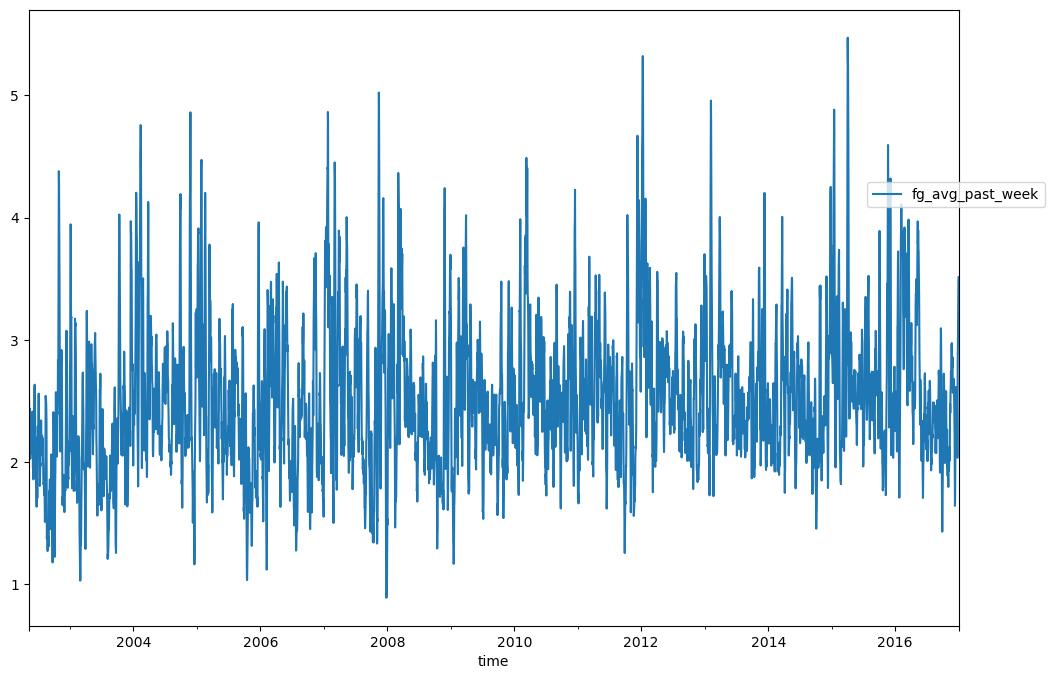

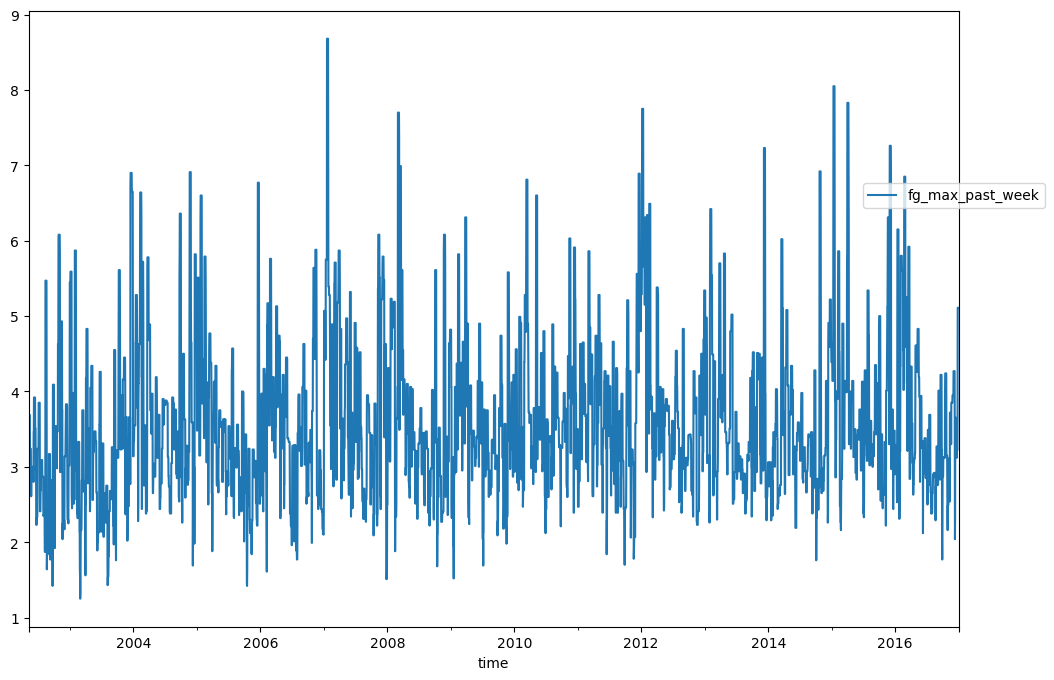

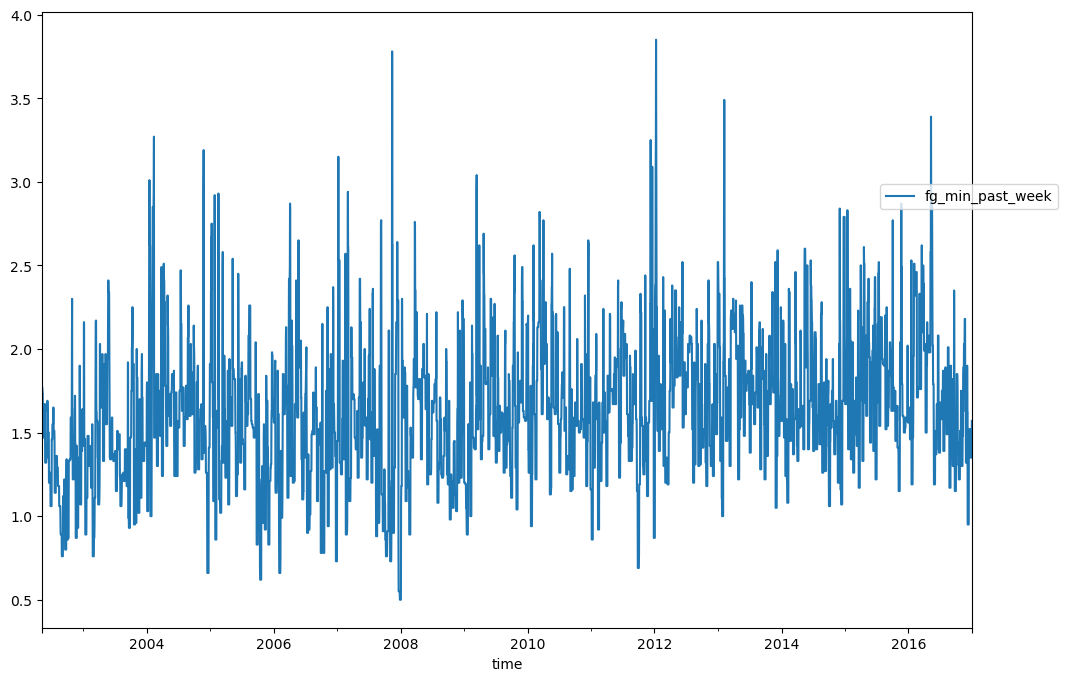

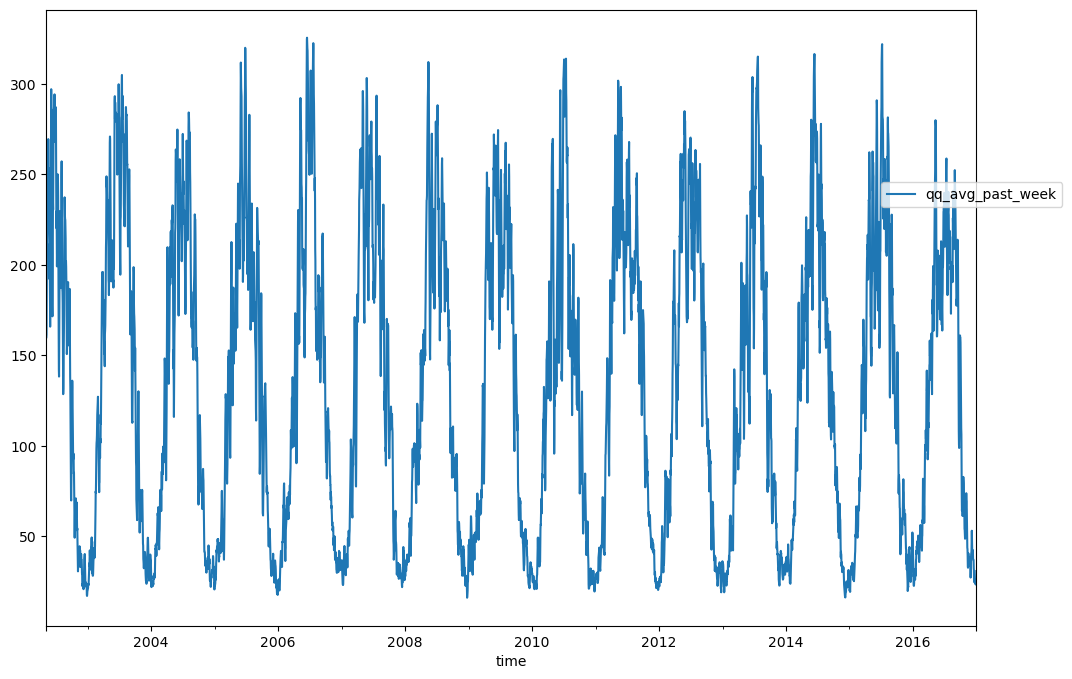

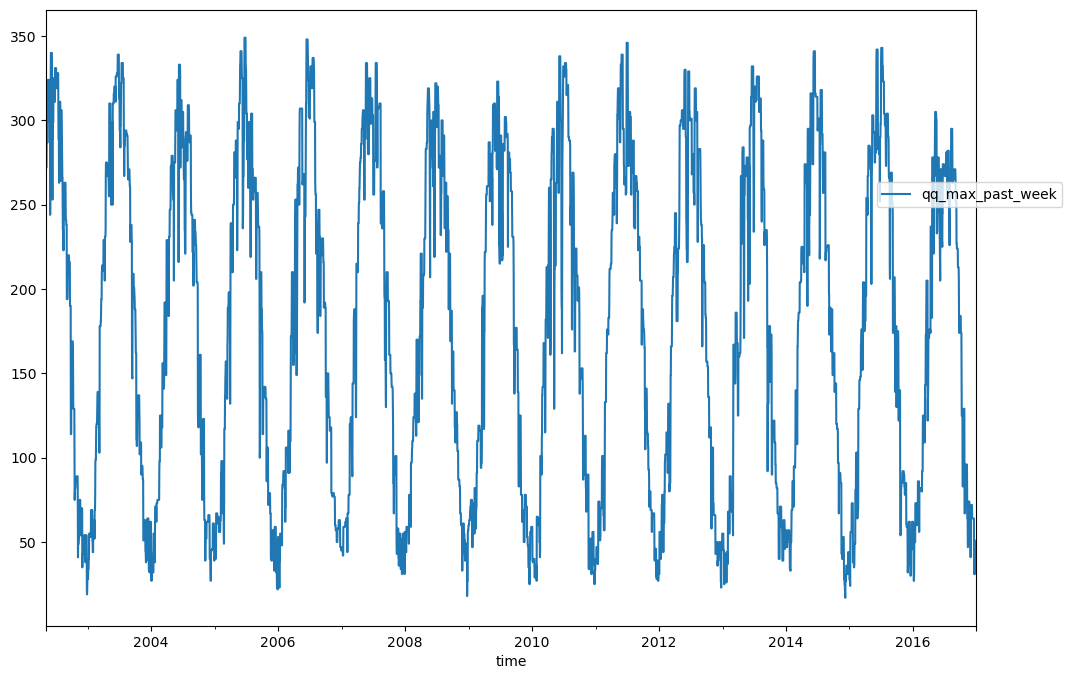

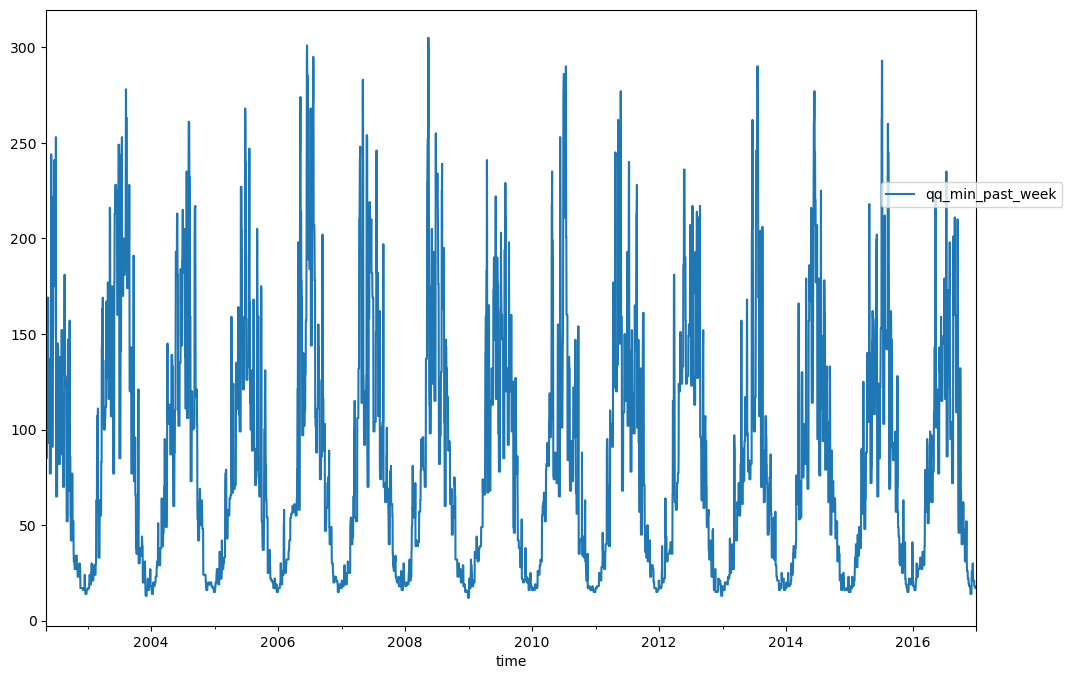

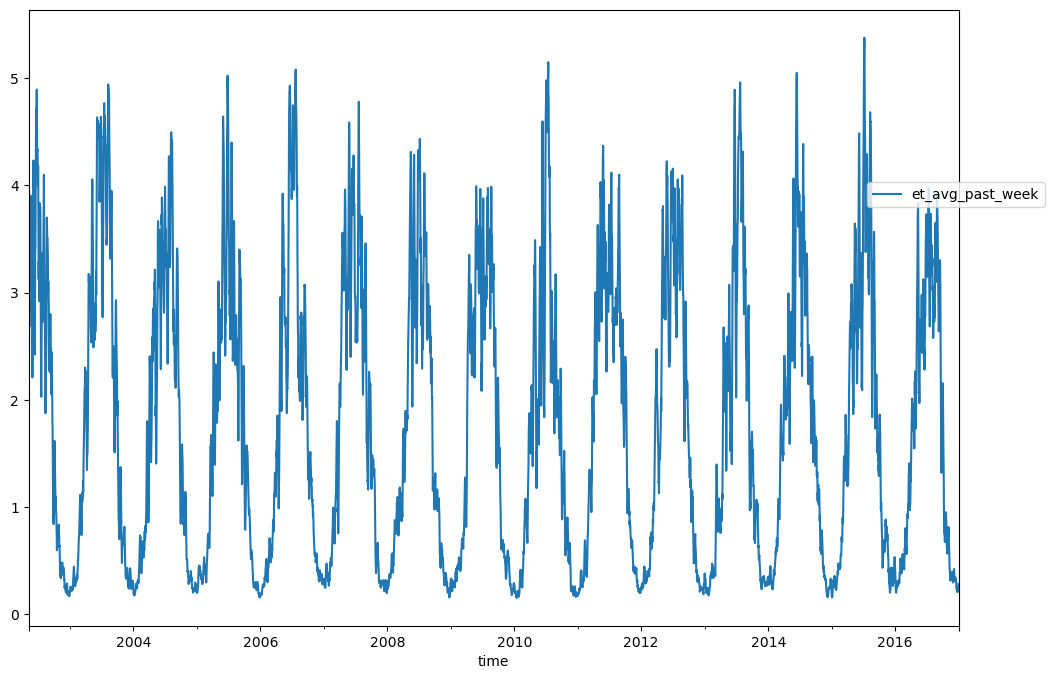

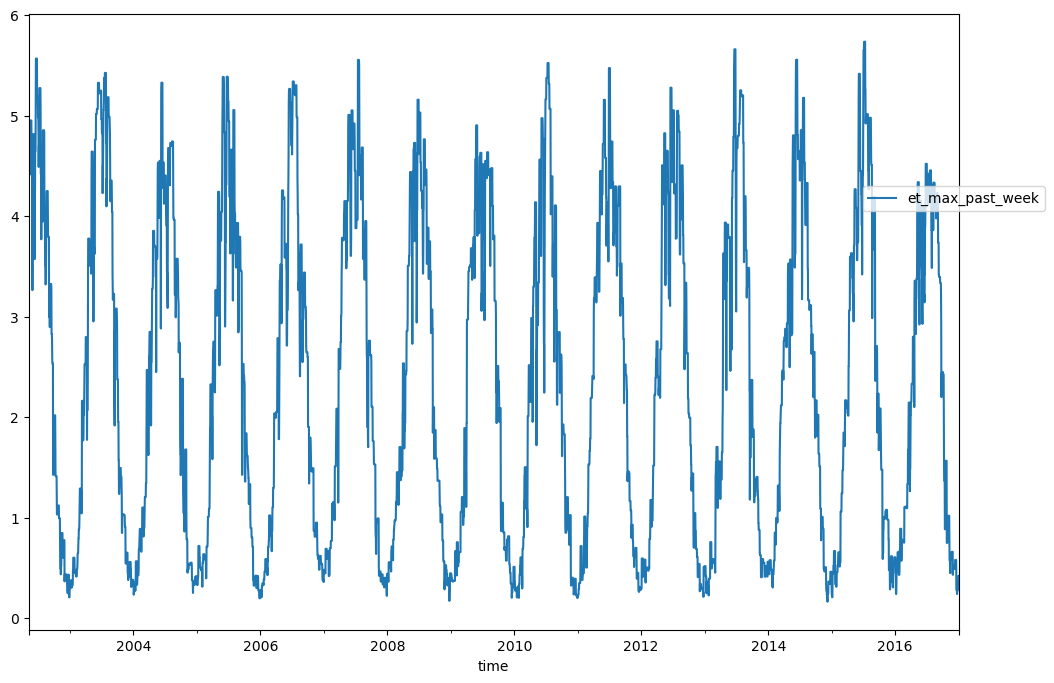

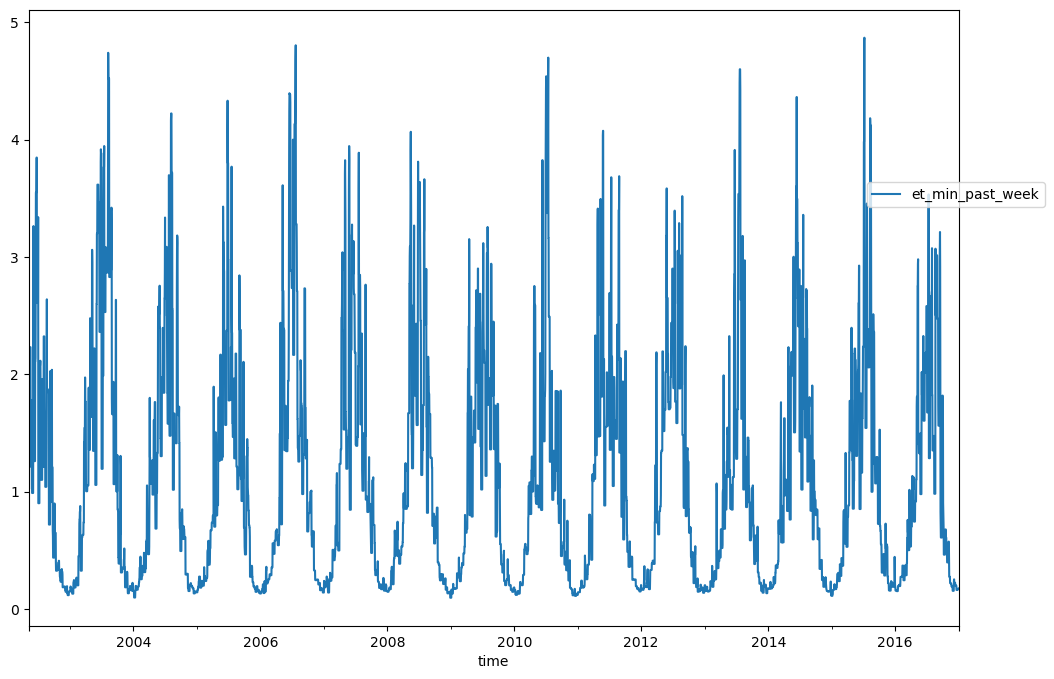

In [18]:
y_ave = np.mean(df_y)
for i in df_X.columns:
    df_X[i].plot(figsize=(12,8))
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.7))
    plt.show()

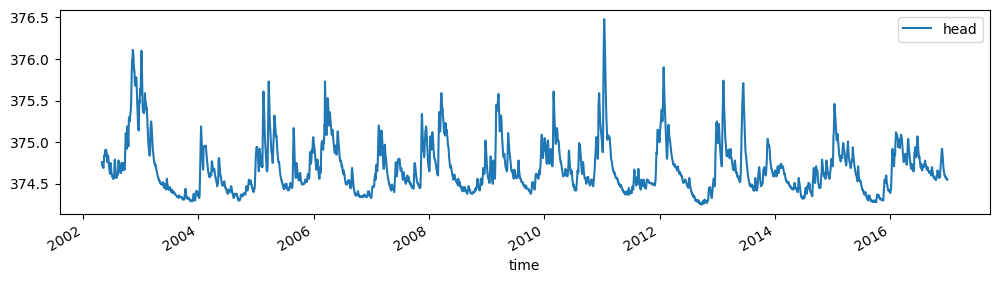

In [6]:
df_y.plot(figsize=(12,3))
plt.show()

In [32]:
df_X.columns

Index(['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et',
       'rr_avg_past_week', 'rr_max_past_week', 'rr_min_past_week',
       'tg_avg_past_week', 'tg_max_past_week', 'tg_min_past_week',
       'tn_avg_past_week', 'tn_max_past_week', 'tn_min_past_week',
       'tx_avg_past_week', 'tx_max_past_week', 'tx_min_past_week',
       'pp_avg_past_week', 'pp_max_past_week', 'pp_min_past_week',
       'hu_avg_past_week', 'hu_max_past_week', 'hu_min_past_week',
       'fg_avg_past_week', 'fg_max_past_week', 'fg_min_past_week',
       'qq_avg_past_week', 'qq_max_past_week', 'qq_min_past_week',
       'et_avg_past_week', 'et_max_past_week', 'et_min_past_week', 'head'],
      dtype='object')

[-0.01497673 -0.02605902 -0.02905539 -0.02931017 -0.02911567 -0.02904122
 -0.0290314  -0.02942545 -0.02994914 -0.02986551]


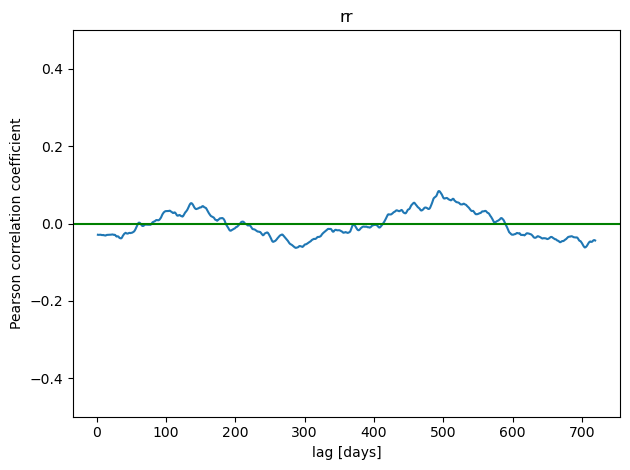

[-0.40304472 -0.40284932 -0.4013328  -0.39916488 -0.39684238 -0.39397279
 -0.39074114 -0.38683276 -0.38185815 -0.37549261]


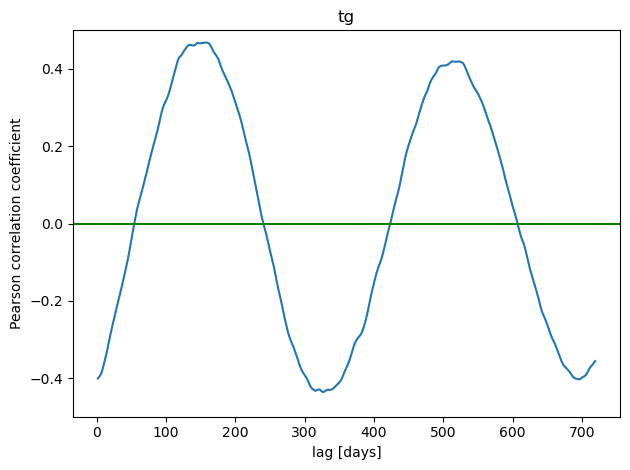

[-0.38450221 -0.39111547 -0.39440718 -0.39580766 -0.39637834 -0.39609932
 -0.3950551  -0.39302631 -0.38935566 -0.38381853]


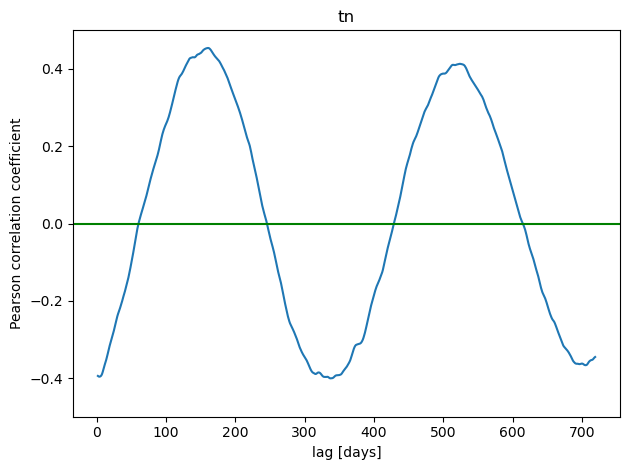

[-0.39685961 -0.3922557  -0.38765951 -0.38301426 -0.378763   -0.37428671
 -0.36981262 -0.36485882 -0.35921948 -0.35262079]


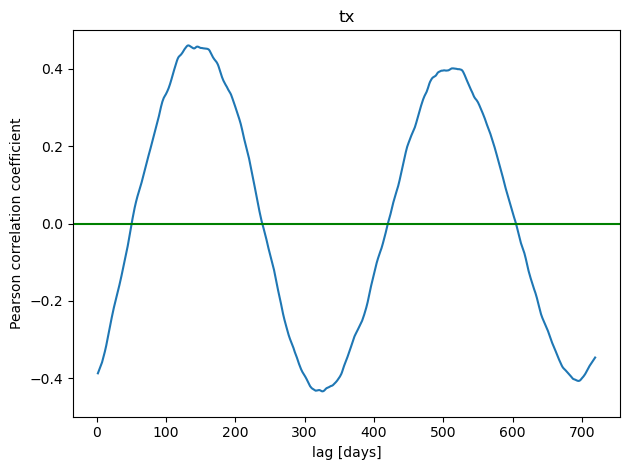

[0.00053707 0.01349232 0.02141763 0.02588986 0.02854369 0.03040801
 0.03269406 0.03550846 0.03842779 0.04056515]


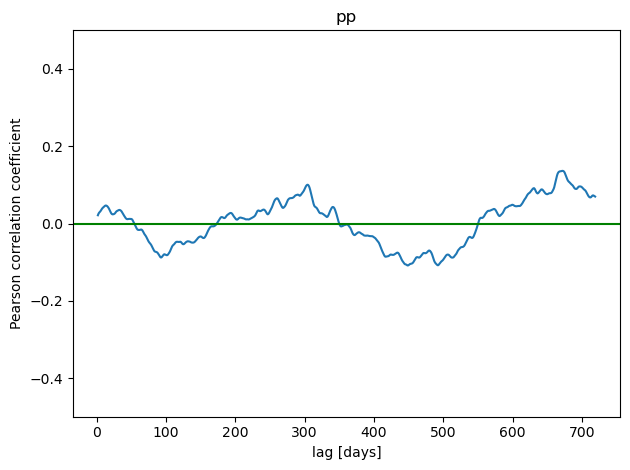

[0.17455067 0.15906523 0.14778115 0.13819851 0.1294843  0.12046711
 0.11198885 0.10399535 0.09621617 0.0887291 ]


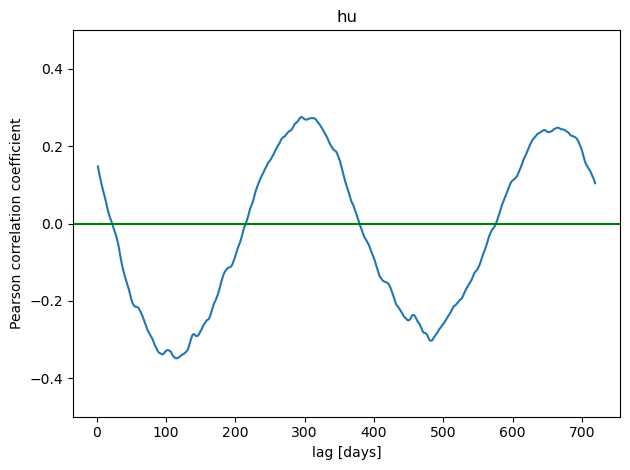

[0.09670997 0.07711337 0.06653413 0.0609243  0.05745091 0.05550848
 0.05467355 0.05378879 0.05237007 0.05119775]


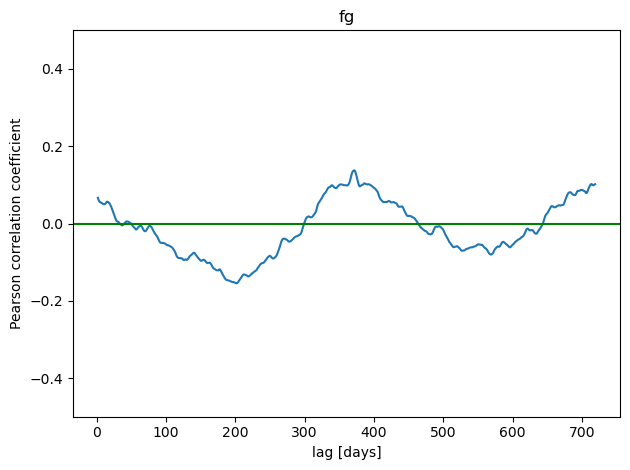

[-0.2303618  -0.21635894 -0.20533624 -0.19564245 -0.18706571 -0.17879048
 -0.17089884 -0.16335279 -0.1561091  -0.14884628]


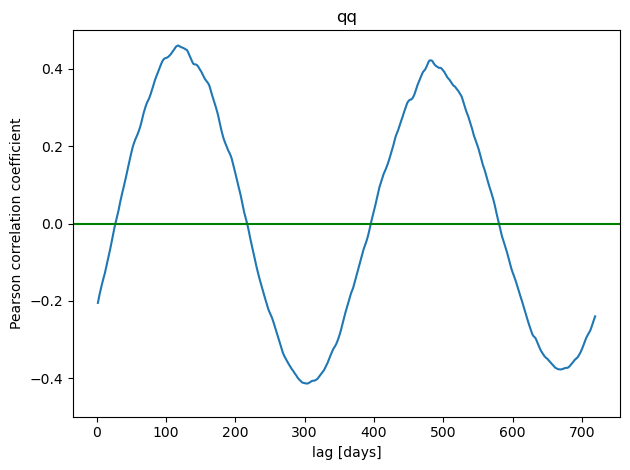

[-0.27080405 -0.25825677 -0.24834321 -0.23980208 -0.23231619 -0.22504286
 -0.21831488 -0.21188312 -0.20551702 -0.19888198]


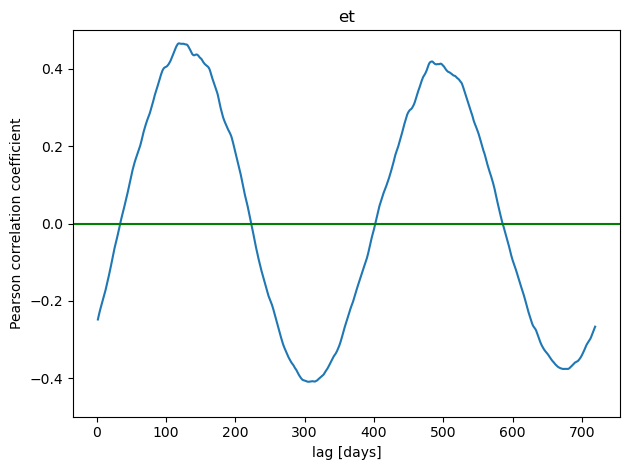

In [38]:
# creating an autocorrelation plot

# new dataframe for the autocorrelation
df_auto = df_X
df_auto['head'] = df_y
lags = np.arange(720)
corr_coefs = np.zeros(720)
for ftr in ['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et']:
    for i in np.arange(len(lags)):
        x = df_auto[ftr].iloc[i:-1].reset_index(drop=True) # recent observations
        y = df_auto['head'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
        #print(x,y)
        # the shapes must be the same
        if x.shape != y.shape:
            raise ValueError('shape mismatch!')
        # Pearson correlation multiplied by the fraction of time series used
        corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/df_auto[ftr].shape[0]
    print(corr_coefs[:10])

    plt.plot(lags[2:],corr_coefs[2:])
    plt.axhline(y=0,color='g')
    plt.ylim([-0.5,0.5])
    plt.xlabel('lag [days]')
    plt.ylabel('Pearson correlation coefficient')
    plt.title(ftr)
    plt.tight_layout()
    plt.show()

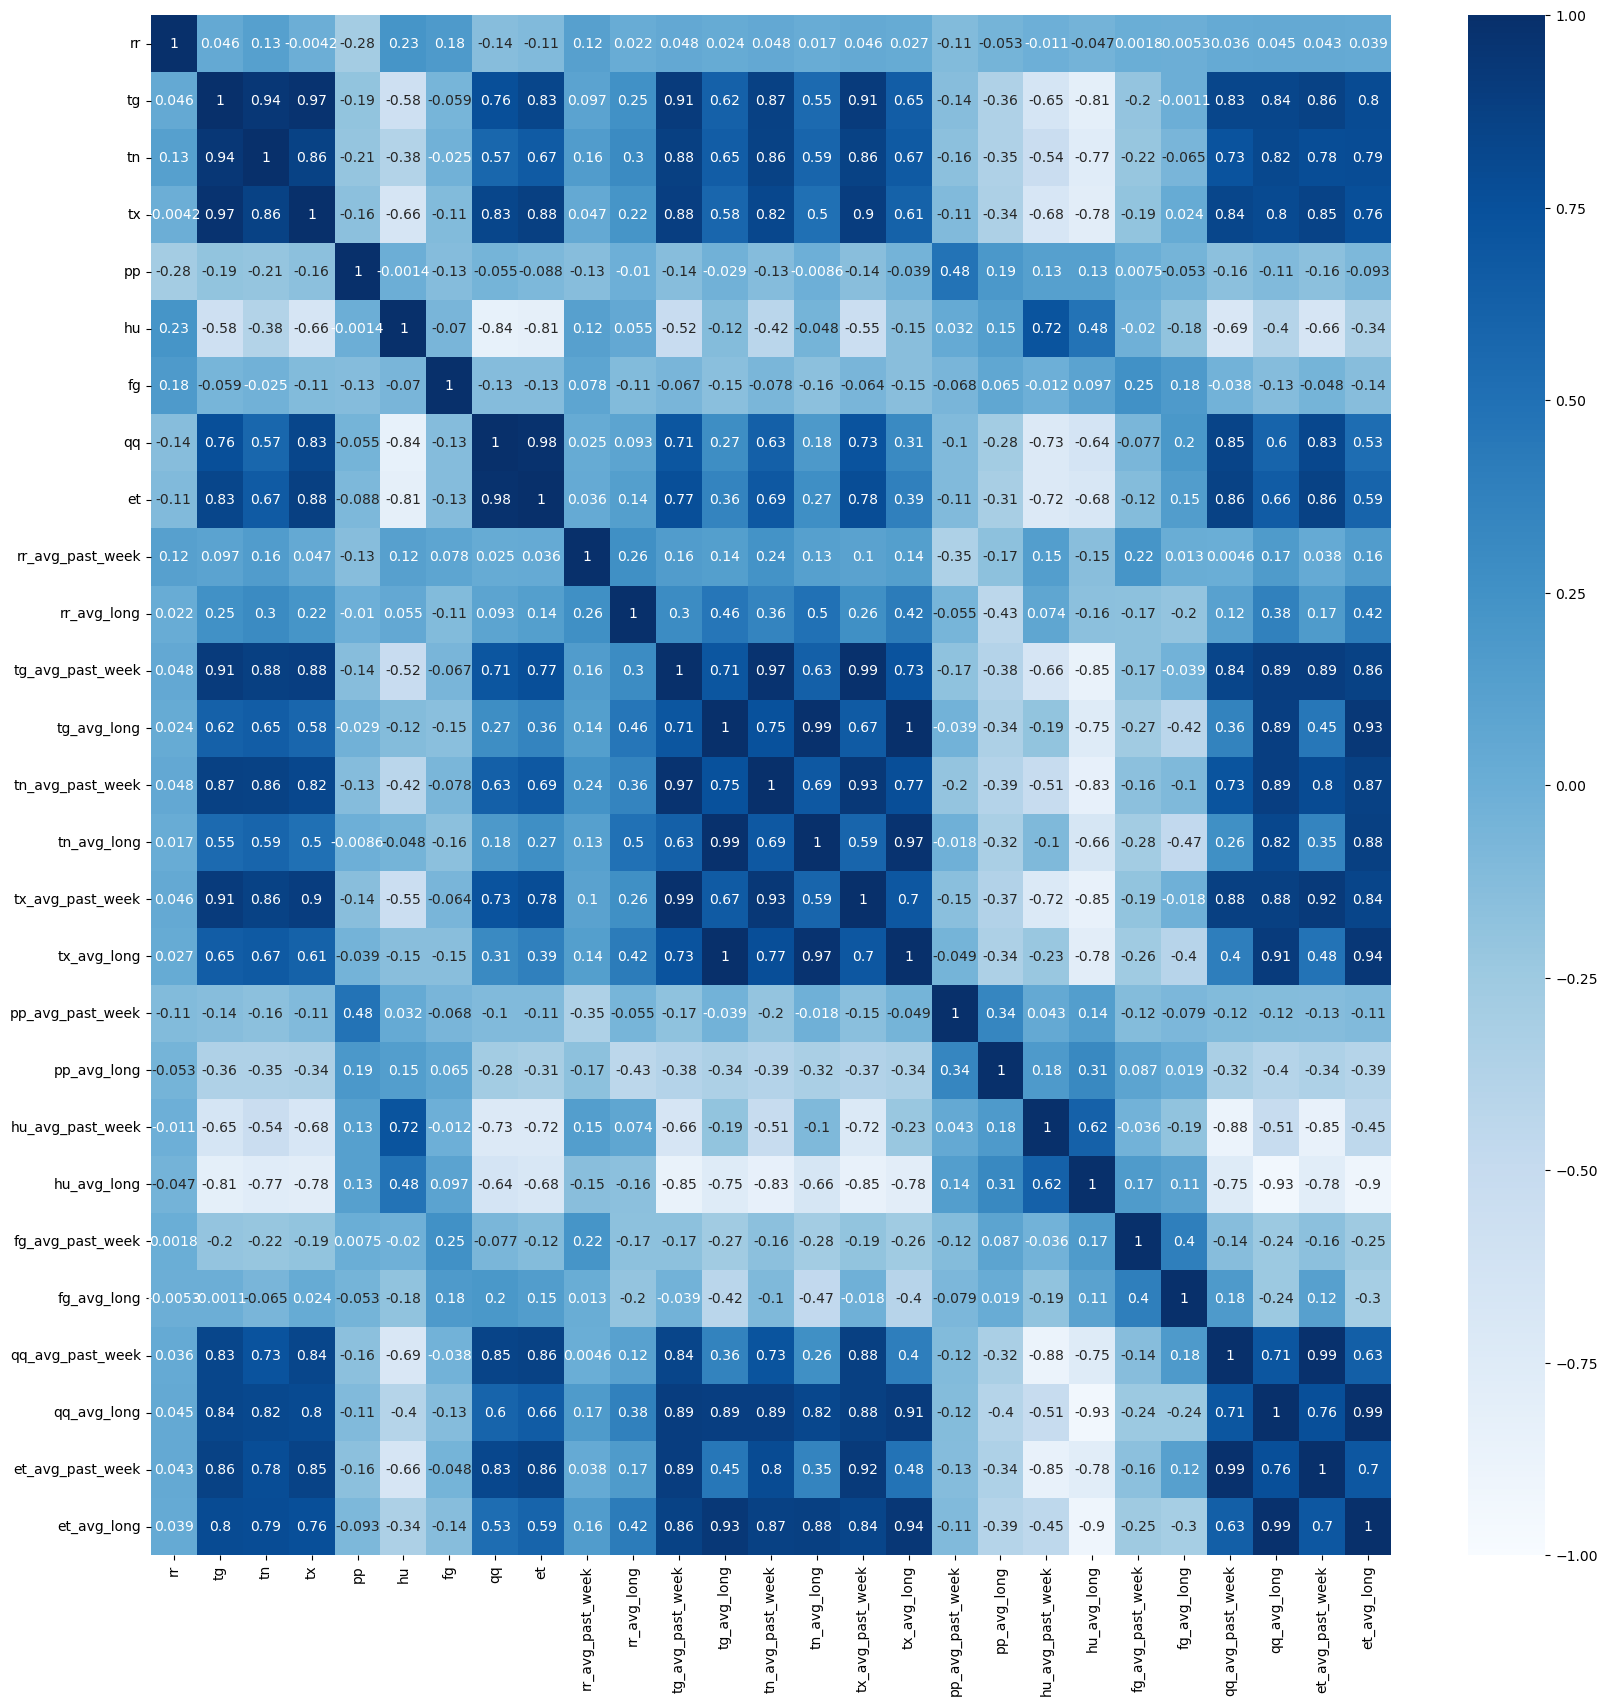

In [65]:
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
# remember to always set the min max values! otherwise will be misleading
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

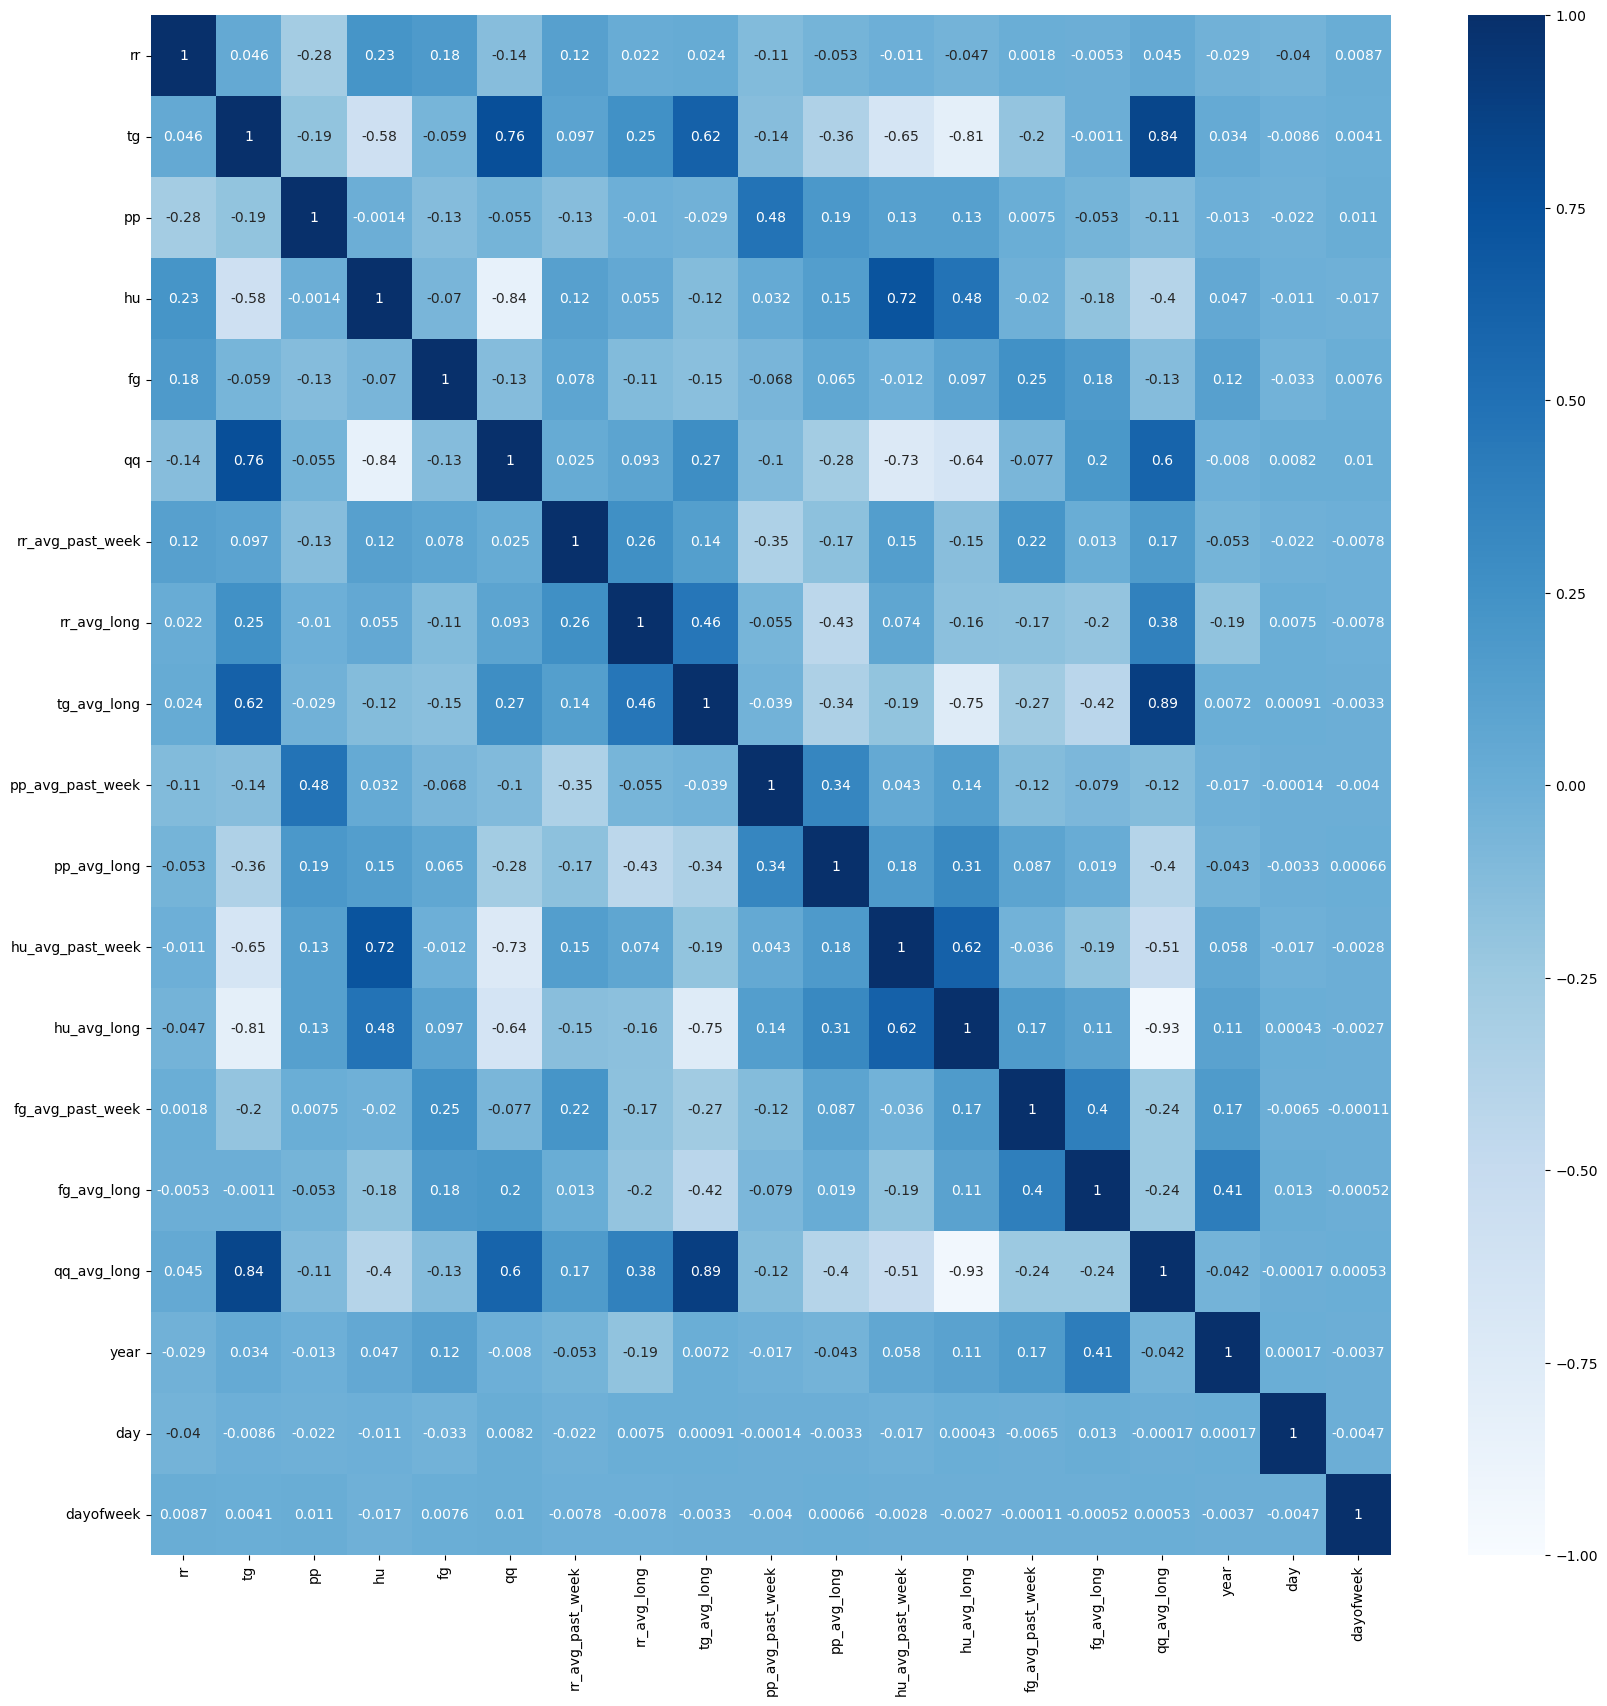

In [69]:
df_X = df_X.drop(columns=[col for col in df_X.columns if (col.startswith('tn') or col.startswith('tx') or col.startswith('et') or col in ['rr_min_past_week','tg_avg_past_week','qq_avg_past_week'])])
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
# remember to always set the min max values! otherwise will be misleading
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

# Modeling

### baseline predction score:

In [78]:
# split
df_y_train = df_y[df_y.index < '2014-01-01']
df_y_val = df_y[df_y.index >= '2014-01-01']

base_y_train = df_y_train
base_y_val = df_y_val

In [79]:
# calculate baseline RMSE
from sklearn.metrics import mean_squared_error

base_y_train['year'] = df_y_train.index.year
base_y_train['month'] = df_y_train.index.month
base_y_train['day'] = df_y_train.index.day

base_prediction = base_y_train.groupby(['month','day'])['head'].mean().reset_index()

base_y_val = df_y_val
base_y_val['month'] = df_y_val.index.month
base_y_val['day'] = df_y_val.index.day

base_y_val = pd.merge(base_y_val, base_prediction, on=['month','day'], how='left')
base_y_val.rename(columns={'head_x':'head_true','head_y':'head_pred'}, inplace=True)

baseline_RMSE = mean_squared_error(base_y_val['head_true'],base_y_val['head_pred'])
baseline_RMSE

/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_34594/2642000833.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_y_train['year'] = df_y_train.index.year
/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_34594/2642000833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_y_train['month'] = df_y_train.index.month
/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_34594/2642000833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

0.046328444004904656

In [45]:
df_y_train.index.year

Int64Index([2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002,
            ...
            2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013],
           dtype='int64', name='time', length=3586)

In [205]:
reg = xgb.XGBRegressor(n_estimators=2000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(df_X_train,df_y_train,eval_set=[(df_X_train,df_y_train),(df_X_val,df_y_val)],verbose=100)

[0]	validation_0-rmse:370.45880	validation_1-rmse:370.38584
[100]	validation_0-rmse:135.63555	validation_1-rmse:135.56244
[200]	validation_0-rmse:49.66085	validation_1-rmse:49.58733
[300]	validation_0-rmse:18.18479	validation_1-rmse:18.11017
[400]	validation_0-rmse:6.66483	validation_1-rmse:6.58835
[500]	validation_0-rmse:2.45479	validation_1-rmse:2.38453
[600]	validation_0-rmse:0.92599	validation_1-rmse:0.86149
[700]	validation_0-rmse:0.38302	validation_1-rmse:0.33575
[800]	validation_0-rmse:0.20704	validation_1-rmse:0.20311
[900]	validation_0-rmse:0.15594	validation_1-rmse:0.19747
[902]	validation_0-rmse:0.15521	validation_1-rmse:0.19757


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Feature Importance

In [206]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=["importance"])

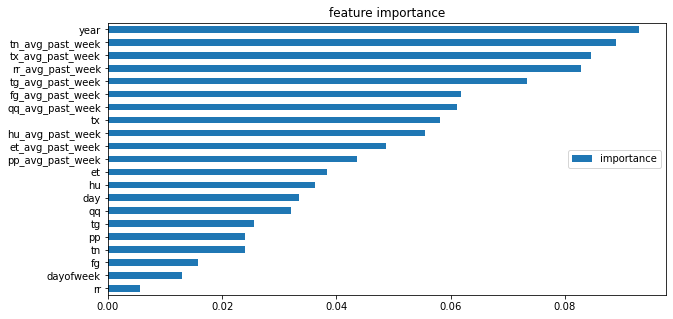

In [207]:
fi.sort_values('importance').plot(kind='barh',title="feature importance",figsize=(10,5))
plt.legend(loc='right')
plt.show()

# pipline

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit


# df_X_train = df_X[df_X.index<'2014-01-01']
# df_y_train = df_y[df_y.index<'2014-01-01']
# df_X_val = df_X[df_X.index>='2014-01-01']
# df_y_val = df_y[df_y.index>='2014-01-01']

# The function which takes the unprocessed feature matrix, target variable, 
# a preprocessor (ColumnTransformer), an initialized ML algorithm, and a correspondig parameter grid as inputs.
def MLpipe_KFold_RMSE(ColumnTransformer, ML_algorithm, parameter_grid):
    
    # collect all the encoders into one preprocessor
    preprocessor = ColumnTransformer

    prep = Pipeline(steps=[('preprocessor', preprocessor)]) 
    
    # Use GridSearchCV and the parameter names need to contain the ML algorithm
    param_grid = parameter_grid 
    
    nr_states = 1 # number of random states
    test_scores = np.zeros(nr_states)
    final_models = []

    for i in range(nr_states):
        # first split to separate out the test set
        # use kfold on other
        feature_matrix_other=df_X[df_X.index<'2014-01-01']
        feature_matrix_test=df_X[df_X.index>='2014-01-01']
        target_variable_other_df=df_y[df_y.index<'2014-01-01']
        target_variable_test_df=df_y[df_y.index>='2014-01-01']
        target_variable_other=target_variable_other_df.values.ravel()
        target_variable_test=target_variable_test_df.values.ravel()

        # splitter for other using k kfold
        tsp = TimeSeriesSplit(n_splits=4)

        # the classifier
        if ML_algorithm in [SVR, KNeighborsRegressor]:
            clf = ML_algorithm()
        else:
            clf = ML_algorithm(random_state = 42*i) # initialize the classifier
        
        
        # put together a pipeline
        # the pipeline will fit_transform the training set (4 folds), and transform the last fold used as validation
        # then it will train the ML algorithm on the training set and evaluate it on the validation set
        # it repeats this step automatically such that each fold will be an evaluation set once
        pipe = make_pipeline(preprocessor,clf)

        # use GridSearchCV
        # GridSearchCV loops through all parameter combinations and collects the results 
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'neg_mean_squared_error',
                            cv=tsp, return_train_score = True, n_jobs=-1, verbose=True)
        
        # this line actually fits the model on other
        grid.fit(feature_matrix_other, target_variable_other)
        # save results into a data frame.
        results = pd.DataFrame(grid.cv_results_)
        print(results)

        print('best model parameters:',grid.best_params_)
        #print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        final_models.append(grid)
        # calculate and save the test score
        target_variable_test_pred = final_models[-1].predict(feature_matrix_test)
        test_scores[i] = (mean_squared_error(target_variable_test,target_variable_test_pred)) #use RMSE as test score
        print('test score:',test_scores[i])
        
        prediction = pd.DataFrame(target_variable_test_pred,index=target_variable_test_df.index)
        ax = target_variable_test_df.plot(figsize=(10,6))
        prediction.plot(ax=ax)
        plt.legend(["test_data","predict"])
        plt.show()
    
    # print out mean and std of test scores
    print('mean of test scores:',np.mean(test_scores))
    #print('standard deviation of test scores:',np.std(test_scores,ddof=1))
    


Fitting 4 folds for each of 11 candidates, totalling 44 fits
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.042255      0.011963         0.016919        0.011194   
1        0.035152      0.009005         0.010973        0.003044   
2        0.032652      0.006563         0.010100        0.002685   
3        0.029066      0.004350         0.017237        0.009467   
4        0.030160      0.010505         0.009710        0.001577   
5        0.037163      0.019691         0.009654        0.002152   
6        0.017831      0.003767         0.008075        0.001177   
7        0.022826      0.007281         0.007376        0.000877   
8        0.022044      0.007768         0.008613        0.002268   
9        0.020613      0.002575         0.005955        0.000826   
10       0.027655      0.007389         0.009726        0.003400   

   param_lasso__alpha                                  params  \
0                0.01                  {'lasso__alpha': 0

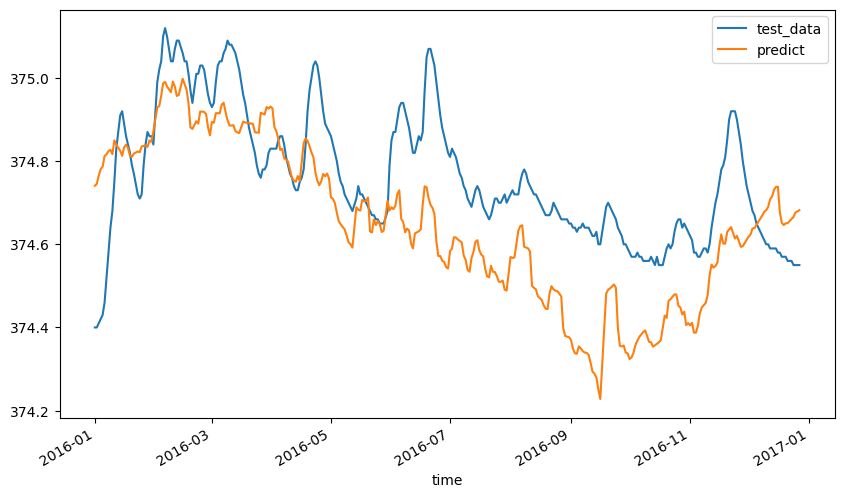

mean of test scores: 0.03287081008234003


In [74]:
# lasso regression with avg_past_week
onehot_ftrs = ['year','day','dayofweek']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]

columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), 
                                                   onehot_ftrs),('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=Lasso
parameter_grid = {'lasso__alpha': np.logspace(-2,2,11)} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_svr__C  \
0        0.408377      0.233697         0.429855        0.196400          0.1   
1        0.478331      0.380276         0.375386        0.156242          0.1   
2        0.751054      0.554110         0.802690        0.384088          0.1   
3        0.524769      0.341623         0.663440        0.289353          0.1   
4        0.833539      0.680829         0.867115        0.472498          0.1   
5        0.400946      0.203581         0.382101        0.161424          1.0   
6        0.398991      0.302858         0.488026        0.351139          1.0   
7        1.336706      0.900809         0.981337        0.292098          1.0   
8        0.758894      0.504325         0.855707        0.373880          1.0   
9        0.825296      0.628746         0.831462        0.338337          1.0   
10       0.868327      0.625100         0.338192

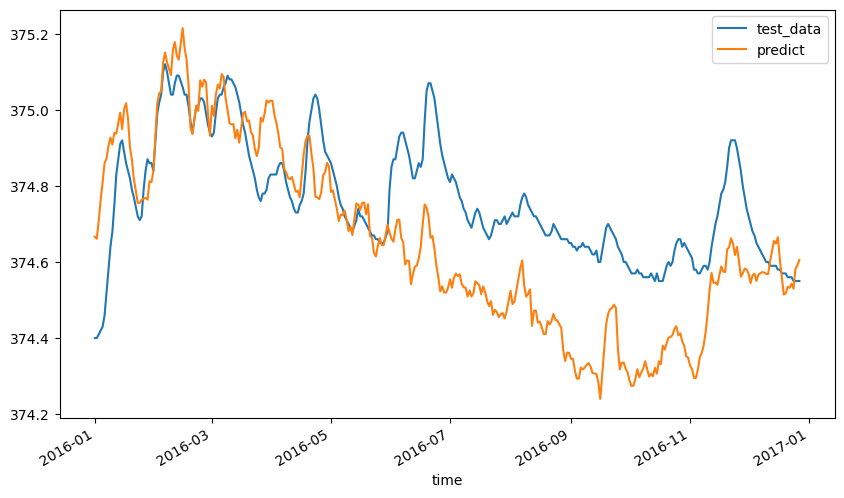

mean of test scores: 0.03987390968260489


In [75]:
# SVR
onehot_ftrs = ['year','day','dayofweek']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=SVR
parameter_grid = {'svr__gamma': [1e-2, 1e-1, 1e1, 1e2, 1e3],'svr__C': [1e-1, 1e0, 1e1]} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.249672      0.026314         0.024368        0.002790   
1        0.367285      0.052929         0.033305        0.006296   
2        0.449185      0.109709         0.029431        0.002786   
3        0.526534      0.185755         0.038131        0.016819   
4        0.335097      0.072979         0.026882        0.005892   
5        0.502260      0.059566         0.032887        0.015160   
6        0.962676      0.326652         0.034145        0.013815   
7        1.487509      0.438428         0.027632        0.003349   
8        1.532369      0.490993         0.030832        0.003781   
9        0.299791      0.020562         0.028082        0.004516   
10       0.329603      0.038559         0.036944        0.009878   
11       0.982973      0.373414         0.032373        0.003627   
12       1.665476      0.681200         0.030124      

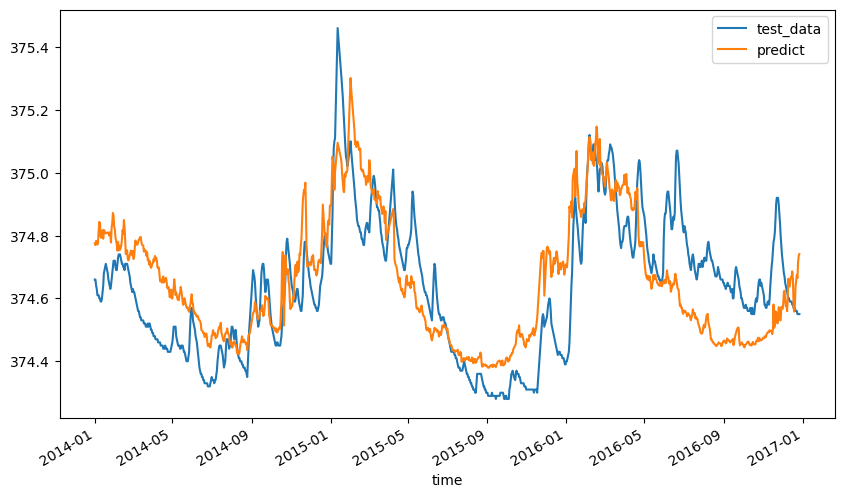

mean of test scores: 0.02385367700265384


In [72]:
# random forest
onehot_ftrs = ['year','day','dayofweek']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=RandomForestRegressor
parameter_grid = {'randomforestregressor__max_depth': [1,5,10,30,50,100],'randomforestregressor__max_features': [0.01,0.25,0.5,0.75,1]} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)